# Hi-Tech Girls Project by Monika Kaczan

The main goal of this projects was to explore relationships between weather and functioning of BTS stations across Poland. I was given the data regarding weather in weather stations, as well as data regarding location and function of BTS stations.

To explore relationships between the weather and functioning of BTS stations, I took the following steps:

1. Data preprocessing
   - Loading and transforming the data regarding the weather
   - Completing the information about weather stations
   - Checking the data correctness
   - Aggregating the data about weather stations
   - Handling missing values
   - Loading the data on BTS stations
   - Assigning BTS stations data on the weather
   - Adding the data on BTS malfunctioning
2. Data analysis
   - Preliminary analysis for the weather stations data
   - Preliminary analysis for the BTS stations data
   - Comparing Orange and other providers
   - Visualization of stations on the map
   - Identification of stations that are exposed to the most extreme weather changes
   - Assesing the impact of weather on BTS malfunctioning
3. Training machine learning models
   - Clustering:
     - K-Means
   - Classification model predicting a high percentage of anomaly occurences
     - Logit
     - Ridge Classifier
     - XGBoost
     - K nearest neighbours
4. Summary
   - Further project development
   - Applying conclusions drawn from the data in practice





Throught the notebook I am using the following variables which are further explained when neccessary (units assumed from the data):
- A - air temperature (°C)
- B - ground temperature (°C)
- C - average wind speed (m/s)
- D - daily total precipitation (mm)
- E - relative air humidity (%)\
- anomalies - according to the definition provided I am refering to the percentage of anomalies in functioning of a BTS station throught the month.

Throught the analysis I have used several additional files, for example Poland shapefile for vizualization or files with ML models that took long time to calculate. All additional files can be used under the following adress:
https://drive.google.com/drive/folders/16Hs369wokL-K5f02Oe99_JSO8CqeYL6V?usp=drive_link



## Data preprocessing

### Loading and transforming the data regarding weather

Loading the data

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Importing libraries

import numpy as np
import pandas as pd

import os
import glob

# Choosing proper data files

path = os. getcwd() + '/data'
csv_files = glob.glob(path + "./[A-E]_*")
df_list = (pd.read_csv(file, encoding = "ISO-8859-2", sep = ";", decimal = ',', low_memory = False) for file in csv_files)

# Combining information from all the files into one dataframe

df_raw = pd.concat(df_list, ignore_index = True)
df_master = df_raw

Exploring the data

In [ ]:
# Let's look at the data and change columns names

df_master.info()
display(df_master)
df_master.columns = ["id", "coef", "date", "value"]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18661850 entries, 0 to 18661849
Data columns (total 4 columns):
 #   Column        Dtype  
---  ------        -----  
 0   ID_stacji     float64
 1   Parametr      object 
 2   Data_godzina  object 
 3   Wartoć       float64
dtypes: float64(2), object(2)
memory usage: 569.5+ MB


,ID_stacji,Parametr,Data_godzina,Wartoć
0,538.0,A,01.01.2017 00:00,7.5
1,538.0,A,01.01.2017 01:00,8.7
2,538.0,A,01.01.2017 02:00,8.7
3,538.0,A,01.01.2017 03:00,9.3
4,538.0,A,01.01.2017 04:00,8.4
...,...,...,...,...
18661845,554.0,E,12.12.2022 12:00,87.0
18661846,554.0,E,12.12.2022 13:00,79.0
18661847,554.0,E,12.12.2022 14:00,77.0
18661848,554.0,E,12.12.2022 15:00,74.0


Handling missing values

In [ ]:
# Let's look at the NAs

df_master.isna().sum()
# We see that we have lot's of NAs

df_master.isnull().any(axis=1).sum()
# However they are just empty rows so we can delete them

df_master = df_master.dropna(how = 'all').reset_index(drop = True)

Handling duplicates

In [ ]:
# Let's check the data for duplicates

# Checking duplictes by rows
df_master[df_master.duplicated()]

# Deleting duplicates
df_master = df_master.drop_duplicates()


# Checking if we have rows with the same ID, Date and Coef but different

df_master[df_master.duplicated(subset = ['id','coef', 'date'])]
# We have observations with the same ID, Coef and Date, but different Value.
# I assume the last (by row number) Value is correct, for example somebody made a mistake and tried to overrite it.

# Deleting those duplicates
df_master = df_master.drop_duplicates(subset = ['id','coef', 'date'], keep = 'last')

Changing data format

In [ ]:
df_master = df_master.astype({'id':'int', 'coef': 'str'})
df_master['date'] = pd.to_datetime(df_master['date'], format = "%d.%m.%Y %H:%M")

Unstacking - we have all parameters in the same column, so we can unstack them and move them to different columns.

In [ ]:
# As we have all parameters in the same column, we can unstack them and move them to different columns.

# First, let's check if parameters are written correctly.

df_master['coef'].unique()
# We see that we have Coef 'B' and 'B '. I assume that it is a mistake so I merge them.

df_master['coef'] = df_master['coef'].replace('B ', 'B')

In [ ]:
# Unstacking

df_unstacked = df_master.pivot_table(index = ['id', 'date'], columns = ['coef'], values = 'value').reset_index()
df_unstacked

# Checking if everything went okay and we have the same number of observations as before

# df_master['Coef'].value_counts(dropna = True).sort_values()
# df_unstacked.count().sort_values()

coef,id,date,A,B,C,D,E
0,1,2017-01-01 06:00:00,NaN,NaN,NaN,3.7,NaN
1,1,2017-01-02 06:00:00,NaN,NaN,NaN,4.0,NaN
2,1,2017-01-03 06:00:00,NaN,NaN,NaN,0.9,NaN
3,1,2017-01-04 06:00:00,NaN,NaN,NaN,5.5,NaN
4,1,2017-01-05 06:00:00,NaN,NaN,NaN,1.7,NaN
...,...,...,...,...,...,...,...
4474783,570,2022-12-31 18:00:00,11.4,12.3,7.0,NaN,85.0
4474784,570,2022-12-31 19:00:00,13.4,12.8,8.6,NaN,91.0
4474785,570,2022-12-31 20:00:00,12.6,12.6,7.5,NaN,87.0
4474786,570,2022-12-31 21:00:00,13.1,13.0,5.9,NaN,101.0


In [ ]:
# Let's check NAs once again

(df_unstacked.isna().sum(axis=1) > 0).sum()/len(df_unstacked) #We see that over 96% of rows contains at least one missing value - we cannot simply delete them

0.9653342236548413

### Completing the information about weather stations

Connecting previously loaded data with data from kody_stacji.csv file

In [ ]:
# Loading the data file

path_codes = os. getcwd() + '/data/kody_stacji.csv'
df_codes = pd.read_csv(path_codes, encoding = "ISO-8859-2", sep = ";", decimal = ',')

In [ ]:
# Let's look and the data and change names and formats

df_codes.info()
display(df_codes)

df_codes.columns = ["id", "name", "lat", "long"]
df_codes = df_codes.astype({'id':'int', 'name': 'str', 'lat': 'str', 'long': 'str'})

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 580 entries, 0 to 579
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   ID                      580 non-null    int64 
 1   Nazwa                   580 non-null    object
 2   Szerokoć geograficzna  580 non-null    object
 3   Długoć geograficzna    580 non-null    object
dtypes: int64(1), object(3)
memory usage: 18.2+ KB


,ID,Nazwa,Szerokoć geograficzna,Długoć geograficzna
0,1,RYBNIK-STODOŁY,50 09 16,18 28 59
1,2,DZIWNÓW,54 01 20,14 43 54
2,3,ZIELENIEC,50 19 48,16 23 39
3,4,MIĘDZYGÓRZE,50 13 06,16 46 23
4,5,MIĘDZYLESIE,50 09 12,16 40 15
...,...,...,...,...
575,576,TUROWO,21 54 06,141
576,577,BUKOWIEC,22 24 49,435
577,578,SITOWIEC,17 45 15,134
578,579,MESZNO,17 08 27,212


In [ ]:
# Merging the data about the weather and about the weather stations

df_ws_merged = pd.merge(df_unstacked, df_codes, on ='id', how ='left')

# Checking if it was correct

# df_merged['Lat'].isnull().values.any()
# df_merged['Long'].isnull().values.any()
# df_merged['Name'].isnull().values.any()

# No nulls so the data was merged okay

In [ ]:
# Let's also add data columns

df_ws_merged['year'] = df_ws_merged['date'].dt.year
df_ws_merged['month'] = df_ws_merged['date'].dt.month
df_ws_merged['day'] = df_ws_merged['date'].dt.day

df_ws_merged

,id,date,A,B,C,D,E,name,lat,long,year,month,day
0,1,2017-01-01 06:00:00,NaN,NaN,NaN,3.7,NaN,RYBNIK-STODOŁY,50 09 16,18 28 59,2017,1,1
1,1,2017-01-02 06:00:00,NaN,NaN,NaN,4.0,NaN,RYBNIK-STODOŁY,50 09 16,18 28 59,2017,1,2
2,1,2017-01-03 06:00:00,NaN,NaN,NaN,0.9,NaN,RYBNIK-STODOŁY,50 09 16,18 28 59,2017,1,3
3,1,2017-01-04 06:00:00,NaN,NaN,NaN,5.5,NaN,RYBNIK-STODOŁY,50 09 16,18 28 59,2017,1,4
4,1,2017-01-05 06:00:00,NaN,NaN,NaN,1.7,NaN,RYBNIK-STODOŁY,50 09 16,18 28 59,2017,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4474783,570,2022-12-31 18:00:00,11.4,12.3,7.0,NaN,85.0,KMIECIN,54 11 16,19 09 50,2022,12,31
4474784,570,2022-12-31 19:00:00,13.4,12.8,8.6,NaN,91.0,KMIECIN,54 11 16,19 09 50,2022,12,31
4474785,570,2022-12-31 20:00:00,12.6,12.6,7.5,NaN,87.0,KMIECIN,54 11 16,19 09 50,2022,12,31
4474786,570,2022-12-31 21:00:00,13.1,13.0,5.9,NaN,101.0,KMIECIN,54 11 16,19 09 50,2022,12,31


### Checking the data correctness

Before proceding to data aggregation and further analysis, I wanted to check the data correctness. To do that, I have taken a look at the basic statistics for the weather variables.

In [ ]:
pd.options.display.float_format = '{:.2f}'.format
df_ws_merged.drop(['id', 'day', 'month', 'year'], axis = 'columns').describe()

,A,B,C,D,E
count,4097786.00,4102060.00,4163982.00,382952.00,4168154.00
mean,8.91,9.77,3.02,2.30,77.15
std,8.59,9.42,10.15,4.63,19.69
min,-23.40,-49.30,0.00,0.00,-10.00
25%,2.00,2.00,1.40,0.40,64.81
50%,8.60,8.80,2.50,0.80,82.24
75%,15.16,16.20,3.90,1.90,93.00
max,50.46,56.60,1000.90,131.10,114.00


Based on the table above, we can identify the following problems with the data:
    
- Variable C - average wind speed: we have very large maximum wind speeds. I assume that the unit for variable C are m/s (based on real data for Poland), so the wind speed of 1000 m/s is unreal and it is likely a incorrect observation.
- Variable E: relative air humidity: according to the definition, relative air humidity cannot be lower than 0 (source: https://en.wikipedia.org/wiki/Humidity#Relative_humidity, https://www.chicagotribune.com/news/ct-xpm-2011-12-16-ct-wea-1216-asktom-20111216-story.html).

The rest of the variables seem reasonable.

Let's first tackle problems with variable C.

In [ ]:
# Based on the statistics, I assume that the problem with high values is in few outliers.
# Let's delete all observations with C value higher than 100 m/s which is approximately the highest wind speed ever recorded in Poland.

df_ws_merged.C = np.where(df_ws_merged.C > 100, np.NaN, df_ws_merged.C)

Now let's correct variable E.

In [ ]:
# I assume that E values below 0 are incorrect. I trasform them into values above 0.
# I delete values equal to 0.

df_ws_merged.E = np.where(df_ws_merged.E < 0, df_ws_merged.E*-1, df_ws_merged.E)
df_ws_merged.E = np.where(df_ws_merged.E == 0, np.NaN, df_ws_merged.E)

### Aggregating the data about weather stations

In the original file the data was provided at the level of hours. However, we have lot's of missing data and analyzing data at such a small level is not sensible.

In this analysis I decided to aggregate the data at the month level, as the other data about BTS stations malfunctions is also aggregated at this level. Moreover, as not only the weather itself, but also its variability may, in my opinion, influence the functioning of BTS stations, I took into account both mean and standard deviation of weather variables across the month.

I have chosen mean as a general indicator of this weather parameter throught the month. I also took standard deviations as a measure of variability of that parameter.

In [ ]:
# Aggregating and calculating monthly means of weather variables

df_month_mean = df_ws_merged.loc[:, df_ws_merged.columns != 'day'].groupby(['id', 'name', 'lat', 'long', 'year', 'month']).mean(numeric_only = True)
df_month_mean.reset_index(inplace = True)


# Aggregating and calculating monthly standard deviations of weather variables

df_month_std = df_ws_merged.loc[:, df_ws_merged.columns != 'Day'].groupby(['id', 'name', 'lat', 'long', 'year', 'month']).std(numeric_only = True)
df_month_std.reset_index(inplace = True)

In [ ]:
# Let's merge both datasets

df_ws = pd.merge(df_month_mean, df_month_std, on = ['id', 'name', 'lat', 'long', 'year', 'month'], how = 'left', suffixes = ('_mean', '_std'))
display(df_ws)

,id,name,lat,long,year,month,A_mean,B_mean,C_mean,D_mean,E_mean,A_std,B_std,C_std,D_std,E_std,day
0,1,RYBNIK-STODOŁY,50 09 16,18 28 59,2017,1,NaN,NaN,NaN,1.45,NaN,NaN,NaN,NaN,1.43,NaN,9.09
1,1,RYBNIK-STODOŁY,50 09 16,18 28 59,2017,2,NaN,NaN,NaN,2.10,NaN,NaN,NaN,NaN,2.57,NaN,8.23
2,1,RYBNIK-STODOŁY,50 09 16,18 28 59,2017,3,NaN,NaN,NaN,1.19,NaN,NaN,NaN,NaN,2.36,NaN,9.09
3,1,RYBNIK-STODOŁY,50 09 16,18 28 59,2017,4,NaN,NaN,NaN,2.36,NaN,NaN,NaN,NaN,3.94,NaN,8.80
4,1,RYBNIK-STODOŁY,50 09 16,18 28 59,2017,5,NaN,NaN,NaN,2.31,NaN,NaN,NaN,NaN,3.74,NaN,9.09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12933,570,KMIECIN,54 11 16,19 09 50,2022,8,21.07,23.16,3.60,2.34,73.54,5.21,6.97,1.68,5.01,19.46,8.95
12934,570,KMIECIN,54 11 16,19 09 50,2022,9,12.45,13.43,3.84,3.41,80.05,3.53,4.75,1.88,4.39,16.52,8.66
12935,570,KMIECIN,54 11 16,19 09 50,2022,10,11.13,11.68,4.18,0.81,86.82,3.31,3.92,1.73,0.90,12.96,8.95
12936,570,KMIECIN,54 11 16,19 09 50,2022,11,4.61,5.40,3.90,1.01,91.05,5.03,4.87,1.44,1.42,8.41,8.60


To make the analysis more clear, I would like to focus only on one year. In the data we have two years: 2017 and 2022.

Let's check if both years are similiar in terms of mean values of monthly weather variables using ANOVA.

In [ ]:
import scipy.stats as stats

years = [2017, 2022]

for variable in df_ws.columns[6:11]:  # Get the parameter columns
    data = [df_ws[df_ws['year'] == year][variable].dropna() for year in years]
    f_statistic, p_value = stats.f_oneway(*data)
    print(variable, p_value)

# Based on p-value we cannot reject the null hypothesis that the corresponding variable means for each year are the same.
# It means that we cannot see statistically significant differences in monthly mean values of parameters between the years.

A_mean 0.9996948316208003
B_mean 0.9915922687044476
C_mean 0.9857310816849617
D_mean 0.992681419316449
E_mean 0.9955805236542822


As both years seem similiar, I choose the most recent year of 2022 and the rest of my analysis will be based only on that data.

In [ ]:
df_ws2022 = df_ws[df_ws['year'] == 2022]
df_ws2022.drop('year', axis = 'columns', inplace = True)
df_ws2022

,id,name,lat,long,month,A_mean,B_mean,C_mean,D_mean,E_mean,A_std,B_std,C_std,D_std,E_std,day
12,1,RYBNIK-STODOŁY,50 09 16,18 28 59,1,NaN,NaN,NaN,1.49,NaN,NaN,NaN,NaN,1.46,NaN,9.09
13,1,RYBNIK-STODOŁY,50 09 16,18 28 59,2,NaN,NaN,NaN,2.06,NaN,NaN,NaN,NaN,2.47,NaN,8.23
14,1,RYBNIK-STODOŁY,50 09 16,18 28 59,3,NaN,NaN,NaN,1.18,NaN,NaN,NaN,NaN,2.39,NaN,9.09
15,1,RYBNIK-STODOŁY,50 09 16,18 28 59,4,NaN,NaN,NaN,2.42,NaN,NaN,NaN,NaN,3.80,NaN,8.80
16,1,RYBNIK-STODOŁY,50 09 16,18 28 59,5,NaN,NaN,NaN,2.31,NaN,NaN,NaN,NaN,3.86,NaN,9.09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12933,570,KMIECIN,54 11 16,19 09 50,8,21.07,23.16,3.60,2.34,73.54,5.21,6.97,1.68,5.01,19.46,8.95
12934,570,KMIECIN,54 11 16,19 09 50,9,12.45,13.43,3.84,3.41,80.05,3.53,4.75,1.88,4.39,16.52,8.66
12935,570,KMIECIN,54 11 16,19 09 50,10,11.13,11.68,4.18,0.81,86.82,3.31,3.92,1.73,0.90,12.96,8.95
12936,570,KMIECIN,54 11 16,19 09 50,11,4.61,5.40,3.90,1.01,91.05,5.03,4.87,1.44,1.42,8.41,8.60


### Handling missing values

Now let's handle the missing values in the dataset. It is important for later analysis, connecting the weather data with BTS stations and modelling.

In [ ]:
sum (df_ws2022.groupby(['id', 'name', 'lat', 'long']).count().month < 6)
# We see that for 20 stations we do not every at least one parameter value for all months.


# For now, let's create new rows for those months and fill them with NAs

all_combinations = pd.MultiIndex.from_product([df_ws2022['id'].unique(), range(1, 13)], names = ['id', 'month'])
all_data = pd.DataFrame(index = all_combinations).reset_index()

df_ws2022 = pd.merge(all_data, df_ws2022, on = ['id', 'month'], how = 'left')

Let's check the correlations between variables - we are working here on mean values for months, as standard deviation have different interpretation.

In [ ]:
corr = df_ws2022[['A_mean', 'B_mean', 'C_mean', 'D_mean', 'E_mean']].corr()
corr.style.background_gradient(cmap = 'coolwarm', axis=None)

# As one could predict, A (air temperature) and B (ground temperature) are very highly correlated.
# Therefore, parameter B is not that important for our analysis, as long as we have value of parameter B and vice versa.

,A_mean,B_mean,C_mean,D_mean,E_mean
A_mean,1.000000,0.991178,-0.286381,0.280946,-0.414059
B_mean,0.991178,1.000000,-0.272443,0.288210,-0.403869
C_mean,-0.286381,-0.272443,1.000000,-0.119223,0.095878
D_mean,0.280946,0.288210,-0.119223,1.000000,0.117561
E_mean,-0.414059,-0.403869,0.095878,0.117561,1.000000


<AxesSubplot: >

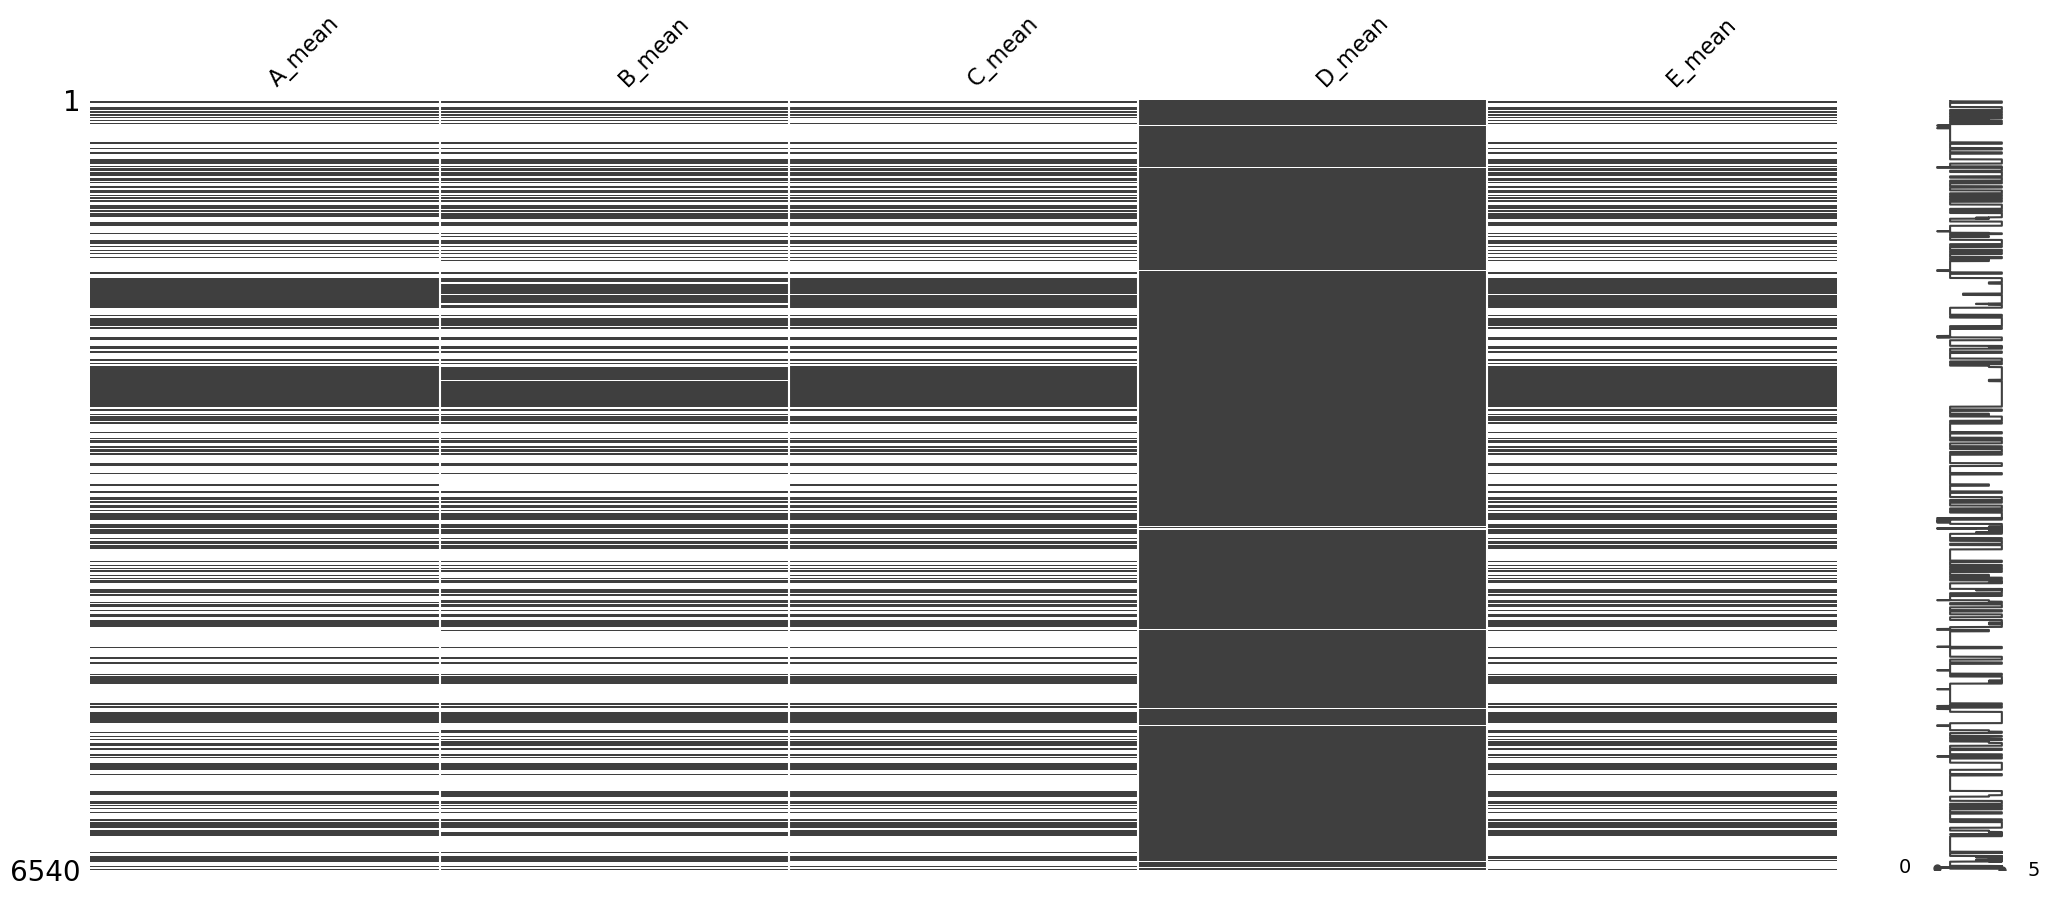

In [ ]:
# Let's explore further how missing value structure looks like

import missingno as mno

(df_ws2022.isna().sum(axis=1) > 0).sum() / len(df_ws2022)
# We still have almost 60% of rows with at least one missing value of parameter

mno.matrix(df_ws2022[['A_mean', 'B_mean', 'C_mean', 'D_mean', 'E_mean']])
# We also see that most observations with missing values have every observation missing except for D parameter value.

In [ ]:
# Let's check number of missing values by ID

NAs_by_ID = df_ws2022.drop(['id', 'name', 'lat', 'long'], 1).isna().groupby(df_ws2022.id, sort = False).sum(numeric_only = True).reset_index()
NAs_by_ID['unhelpful_parameters'] = (NAs_by_ID.iloc[:, 2:] == 12).sum(axis=1) / 2 # Count how many parameters are missing for all months for specific ID

Weather stations for which we have data for only one or two parameters for the whole year (i.e. for a particular parameter they have NAs in all months) are little helpful in our analysis. In theory, we could extrapolate the value of missing parameters, for example by looking at other nearby stations or trying to derive it from the values of other parameters. However, it would be complicated and time-consuming and/or without the guarantee of good results (correlations are not that high except for A and B). I also checked if maybe we can subsitute it with data from the 2017, but from my brief checking (code not included here, I just changed the selected year above and performed the same calculations) we wouldn't get much more information.

Therefore I decided to drop every station that have less than 4 out of 5 parameters (or 3 of 4 if we assume that A and B are carring the same information).

In [ ]:
# Let's check for how many observations we have less than 4 out of 5 parameters present - we are going to delete those

sum(NAs_by_ID['unhelpful_parameters'] >= 3) # Unfortunately it is 300 stations which is more than a half of all our data :(

# As we have seen in correlogram A can subsitute for B and vice versa. Let's check if we could have such situation.
NAs_by_ID[(NAs_by_ID['A_mean'] + NAs_by_ID['B_mean']) == 12]
good_A_B = np.array(NAs_by_ID[(NAs_by_ID['A_mean'] + NAs_by_ID['B_mean']) == 12]['id'].drop(NAs_by_ID.index[137]))

# Deleting stations with more than 3 unhelpful parameters, except these exceptions above
bad_parameters = np.array(NAs_by_ID[NAs_by_ID['unhelpful_parameters'] >= 3]['id'])
df_ws2022d = df_ws2022[~df_ws2022['id'].isin(bad_parameters) | df_ws2022['id'].isin(good_A_B)].copy()
df_ws2022d.reset_index(inplace = True)

(df_ws2022d.isna().sum(axis=1) > 0).sum() / len(df_ws2022d)
# Now we only have around 10% of parameters missing

0.10306122448979592

The missing values for A can be extrapolated from missing values of B and vice versa. Here I am using, well, maybe not the most correct approach but simple and I would say effective enough for those few observations (I could do PCA and take the first principal component as some general indicator of temperature, but it would be more complex and I would prefer for now to stick with original values).

I check how, in most cases, the relationship between A and B looks like and infer the value of one of the missing parameters from it if possible.

In [ ]:
coef_mean = (df_ws2022d['A_mean'] / df_ws2022d['B_mean']).median()
coef_std = (df_ws2022d['A_std'] / df_ws2022d['B_std']).median()

df_ws2022d['A_mean'] = df_ws2022d.apply(lambda row: row['B_mean']*coef_mean if np.isnan(row['A_mean']) else row['A_mean'], axis=1)
df_ws2022d['B_mean'] = df_ws2022d.apply(lambda row: row['A_mean']/coef_mean if np.isnan(row['B_mean']) else row['B_mean'], axis=1)

df_ws2022d['A_std'] = df_ws2022d.apply(lambda row: row['B_std']*coef_mean if np.isnan(row['A_std']) else row['A_std'], axis=1)
df_ws2022d['B_std'] = df_ws2022d.apply(lambda row: row['A_std']/coef_mean if np.isnan(row['B_std']) else row['B_std'], axis=1)

For the rest of the missing values, I fill them based with median value for a particular parameter for Poland for a particular month.

In [ ]:
month_medians = df_ws2022d.groupby('month').median(numeric_only = True)

def fill_NAs(row, variable):
    if pd.isnull(row[variable]):
        return month_medians.loc[row['month'], variable]
    else:
        return row[variable]

for variable in df_ws2022d.columns[6:]:
    df_ws2022d[variable] = df_ws2022d.apply(lambda row: fill_NAs(row, variable), axis=1)

In [ ]:
df_ws2022d[df_ws2022d.isna().any(axis=1)]
# There were some missing Name, Lat and Lot values from the previous operation of filling in NAs for missing months.
# I checked them and they are okay, not the result of an error, so I am filling them in.

df_ws2022d.fillna(method='ffill', inplace = True)

In [ ]:
df_ws2022d

,index,id,month,name,lat,long,A_mean,B_mean,C_mean,D_mean,E_mean,A_std,B_std,C_std,D_std,E_std,day
0,12,2,1,DZIWNÓW,54 01 20,14 43 54,2.89,3.05,8.22,1.84,86.59,2.53,2.66,4.27,2.36,11.27,8.95
1,13,2,2,DZIWNÓW,54 01 20,14 43 54,4.39,4.42,8.05,5.28,81.73,2.11,2.14,3.91,7.01,11.29,8.08
2,14,2,3,DZIWNÓW,54 01 20,14 43 54,4.33,4.40,5.07,0.55,70.66,3.28,3.35,2.42,0.29,23.09,8.95
3,15,2,4,DZIWNÓW,54 01 20,14 43 54,6.73,8.39,7.35,1.44,77.06,2.74,3.79,3.89,2.39,13.27,8.66
4,16,2,5,DZIWNÓW,54 01 20,14 43 54,13.18,15.11,5.70,1.72,73.33,3.36,4.86,3.34,2.42,15.24,8.95
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2935,6535,570,8,KMIECIN,54 11 16,19 09 50,21.07,23.16,3.60,2.34,73.54,5.21,6.97,1.68,5.01,19.46,8.95
2936,6536,570,9,KMIECIN,54 11 16,19 09 50,12.45,13.43,3.84,3.41,80.05,3.53,4.75,1.88,4.39,16.52,8.66
2937,6537,570,10,KMIECIN,54 11 16,19 09 50,11.13,11.68,4.18,0.81,86.82,3.31,3.92,1.73,0.90,12.96,8.95
2938,6538,570,11,KMIECIN,54 11 16,19 09 50,4.61,5.40,3.90,1.01,91.05,5.03,4.87,1.44,1.42,8.41,8.60


### Loading the data on BTS

Loading the data from bts.cv file

In [ ]:
path_bts = os. getcwd() + '/data/bts.csv'

df_bts = pd.read_csv(path_bts, decimal = ',', encoding = "utf-8")
df_bts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9918 entries, 0 to 9917
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   bts_id       9918 non-null   int64 
 1   siec         9918 non-null   object
 2   standard     9918 non-null   object
 3   lokalizacja  9918 non-null   object
dtypes: int64(1), object(3)
memory usage: 310.1+ KB


In [ ]:
# Changing column names and types

df_bts.columns = ["bts_id", "provider", "technology", "location"]
df_bts = df_bts.astype({'provider': 'str', 'technology': 'str', 'location': 'str'})
df_bts.standard = df_bts.technology.str.strip()
df_bts

,bts_id,provider,technology,location
0,0,Konkurent_2,LTE IOT,Nowy Wiśnicz
1,1,Konkurent_2,GSM LTE,Piaski
2,2,Orange,GSM,Katowice
3,3,Konkurent_2,LTE,Sępopol
4,4,Konkurent_3,LTE,Debrzno
...,...,...,...,...
9913,9913,Konkurent_2,UMTS 5G,Błonie
9914,9914,Konkurent_2,LTE,Sandomierz
9915,9915,Orange,LTE,Gozdnica
9916,9916,Konkurent_2,UMTS LTE,Nowy Staw


Creating binary variables representing technologies supported by stations.

In [ ]:
df_bts['technology'] = df_bts['technology'].apply(lambda x: x.split())
df_bts
unique_names = set(name for names in df_bts['technology'] for name in names)

for name in unique_names:
    df_bts[name] = df_bts['technology'].apply(lambda x: 1 if name in x else 0)

df = df_bts.drop(['technology'], axis=1)
df_bts

,bts_id,provider,technology,location,5G,LTE,IOT,GSM,UMTS
0,0,Konkurent_2,"[LTE, IOT]",Nowy Wiśnicz,0,1,1,0,0
1,1,Konkurent_2,"[GSM, LTE]",Piaski,0,1,0,1,0
2,2,Orange,[GSM],Katowice,0,0,0,1,0
3,3,Konkurent_2,[LTE],Sępopol,0,1,0,0,0
4,4,Konkurent_3,[LTE],Debrzno,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...
9913,9913,Konkurent_2,"[UMTS, 5G]",Błonie,1,0,0,0,1
9914,9914,Konkurent_2,[LTE],Sandomierz,0,1,0,0,0
9915,9915,Orange,[LTE],Gozdnica,0,1,0,0,0
9916,9916,Konkurent_2,"[UMTS, LTE]",Nowy Staw,0,1,0,0,1


Loading the coordinates of cities where BTS stations are located

Unfortunately, due to large amount of locations to process, mapping all coordinates using Geopy took quite a long time and quickly I got timeout. This is why my primarly method of mapping coordinates of BTS stations was using an exteranl source - the website https://astronomia.zagan.pl/art/wspolrzedne.html. I copy pasted the data to Excel and tranformed it there as it was much quicker and simpler than direct webscrapping. Next, I loaded this Excel file miejscowosci_lista.csv  here and did the coordinates mapping. Only when there was some problem with mergining the data I used Geopy.

Some of the city names in the bts.csv file were ambiguous as in Poland we can have more than one city with the same name (there are unique only to powiats). In this case I assumed that I can assign the first coordinates by alphabetical order of powiat name that the city belongs to.

Dane zapisałam w pliku miejscowosci_lista.csv.

In [ ]:
# Loading the preprepared file based on information from the website https://astronomia.zagan.pl/art/wspolrzedne.html

path_cities = os. getcwd() + '\\miejscowosci_lista.csv'

df_cities_list = pd.read_csv(path_cities, encoding = "utf-8")
df_cities_list
df_cities_list.drop_duplicates(subset = ['location'], inplace = True) # Powiat names were deleted from location names before, here I delete duplicates created

In [ ]:
# Changing data type

df_cities_list = df_cities_list.astype({'location': 'str', 'long': 'str', 'lat': 'str'})
df_cities_list

# Ujednolicanie nazw i zapisu

df_cities_list.location = df_cities_list.location.str.strip()
df_bts.location = df_bts.location.str.strip()

df_cities_list = df_cities_list.replace('°', '.', regex = True)

Mapping

In [ ]:
df_bts_coor = pd.merge(df_bts, df_cities_list, on ='location', how = 'left')
df_bts_coor

,bts_id,provider,technology,location,5G,LTE,IOT,GSM,UMTS,long,lat
0,0,Konkurent_2,"[LTE, IOT]",Nowy Wiśnicz,0,1,1,0,0,20.27,49.55
1,1,Konkurent_2,"[GSM, LTE]",Piaski,0,1,0,1,0,17.04,51.53
2,2,Orange,[GSM],Katowice,0,0,0,1,0,19.00,50.15
3,3,Konkurent_2,[LTE],Sępopol,0,1,0,0,0,21.01,54.16
4,4,Konkurent_3,[LTE],Debrzno,0,1,0,0,0,17.14,53.33
...,...,...,...,...,...,...,...,...,...,...,...
9913,9913,Konkurent_2,"[UMTS, 5G]",Błonie,1,0,0,0,1,20.36,52.12
9914,9914,Konkurent_2,[LTE],Sandomierz,0,1,0,0,0,21.45,50.41
9915,9915,Orange,[LTE],Gozdnica,0,1,0,0,0,15.06,51.26
9916,9916,Konkurent_2,"[UMTS, LTE]",Nowy Staw,0,1,0,0,1,19.00,54.03


In [ ]:
# If location could not be found, I used Geopy mapping

lista_miast = df_bts_coor[df_bts_coor.long.isnull()].location.unique()

from geopy.geocoders import Nominatim

geolocator = Nominatim(user_agent = "request_Monika")

latitudes = [geolocator.geocode(miasto + ', Polska').latitude for miasto in lista_miast]
longitudes = [geolocator.geocode(miasto + ', Polska').longitude for miasto in lista_miast]

In [ ]:
geopy_mapped = pd.DataFrame({'location': lista_miast, 'long2': longitudes, 'lat2': latitudes})

Merging coordinates data from the website and from the geopy mapping

In [ ]:
df_bts_coor_merged = pd.merge(df_bts_coor, geopy_mapped, on ='location', how ='left')

df_bts_coor_merged['long'].fillna(df_bts_coor_merged['long2'], inplace = True)
df_bts_coor_merged['lat'].fillna(df_bts_coor_merged['lat2'], inplace = True)
df_bts_coor_merged = df_bts_coor_merged.drop(['lat2', 'long2'], axis = 1)
df_bts_coor_merged

,bts_id,provider,technology,location,5G,LTE,IOT,GSM,UMTS,long,lat
0,0,Konkurent_2,"[LTE, IOT]",Nowy Wiśnicz,0,1,1,0,0,20.27,49.55
1,1,Konkurent_2,"[GSM, LTE]",Piaski,0,1,0,1,0,17.04,51.53
2,2,Orange,[GSM],Katowice,0,0,0,1,0,19.00,50.15
3,3,Konkurent_2,[LTE],Sępopol,0,1,0,0,0,21.01,54.16
4,4,Konkurent_3,[LTE],Debrzno,0,1,0,0,0,17.14,53.33
...,...,...,...,...,...,...,...,...,...,...,...
9913,9913,Konkurent_2,"[UMTS, 5G]",Błonie,1,0,0,0,1,20.36,52.12
9914,9914,Konkurent_2,[LTE],Sandomierz,0,1,0,0,0,21.45,50.41
9915,9915,Orange,[LTE],Gozdnica,0,1,0,0,0,15.06,51.26
9916,9916,Konkurent_2,"[UMTS, LTE]",Nowy Staw,0,1,0,0,1,19.00,54.03


### Assigning BTS stations data on the weather

We have already loaded the data on weather stations and data on BTS stations. To analyze the relationship between the weather and BTS station malfuntioning, we need to assing every BTS station a weather stations from which we can infer the weather at the location of this particular BTS station.

Of course, we could assign more than one weather station to the BTS station and take, let's say a mean of weather variables weighted by the distance of particular weather station to that weather location. However, it seems like as unnecceary complication given the time and scope of this project. Although assigning each BTS station just one weather station means that we will have multiple BTS stations with the same weather data.

Let's prepare df with weather data

In [ ]:
# Ujednolicenie współrzędnych do systemu dziesiętnego
def coordinate_split(x):
    deg, minutes, seconds =  x.strip().split()
    return (float(deg) + float(minutes)/60 + float(seconds)/(60*60))

df_ws2022d[['lat', 'long']] = df_ws2022d[['lat', 'long']].applymap(coordinate_split)

stacje_pogoda = df_ws2022d[['id', 'lat', 'long']].drop_duplicates(ignore_index = True)
stacje_pogoda = stacje_pogoda.astype({'lat': 'float', 'long': 'float'})

df_bts_coor_merged = df_bts_coor_merged.astype({'long': 'float', 'lat': 'float'})
df_bts_coor_merged

,bts_id,provider,technology,location,5G,LTE,IOT,GSM,UMTS,long,lat
0,0,Konkurent_2,"[LTE, IOT]",Nowy Wiśnicz,0,1,1,0,0,20.27,49.55
1,1,Konkurent_2,"[GSM, LTE]",Piaski,0,1,0,1,0,17.04,51.53
2,2,Orange,[GSM],Katowice,0,0,0,1,0,19.00,50.15
3,3,Konkurent_2,[LTE],Sępopol,0,1,0,0,0,21.01,54.16
4,4,Konkurent_3,[LTE],Debrzno,0,1,0,0,0,17.14,53.33
...,...,...,...,...,...,...,...,...,...,...,...
9913,9913,Konkurent_2,"[UMTS, 5G]",Błonie,1,0,0,0,1,20.36,52.12
9914,9914,Konkurent_2,[LTE],Sandomierz,0,1,0,0,0,21.45,50.41
9915,9915,Orange,[LTE],Gozdnica,0,1,0,0,0,15.06,51.26
9916,9916,Konkurent_2,"[UMTS, LTE]",Nowy Staw,0,1,0,0,1,19.00,54.03


Let's calculate the distance between weather stations and BTS stations using the Haversin formular. Next, each BTS station we will asssign weather station that is in the closest distance to it.

In [ ]:
from math import radians, sin, cos, sqrt, atan2
from scipy.spatial.distance import cdist

def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Radius of the Earth in kilometers
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    a = sin(dlat / 2) ** 2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon / 2) ** 2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = R * c
    return distance

# Function to find the nearest location in df2 for a given location in df1
def find_nearest_location(row):
    distances = stacje_pogoda.apply(lambda x: haversine(row['lat'], row['long'], x['lat'], x['long']), axis=1)
    min_distance_index = distances.idxmin()
    nearest_location = int(stacje_pogoda.loc[min_distance_index, 'id'])
    min_distance = distances[min_distance_index]
    return nearest_location, min_distance

df_bts_coor_merged[['near_w_station', 'dist_near_w_station']] = df_bts_coor_merged.apply(find_nearest_location, axis=1, result_type='expand')

<AxesSubplot: >

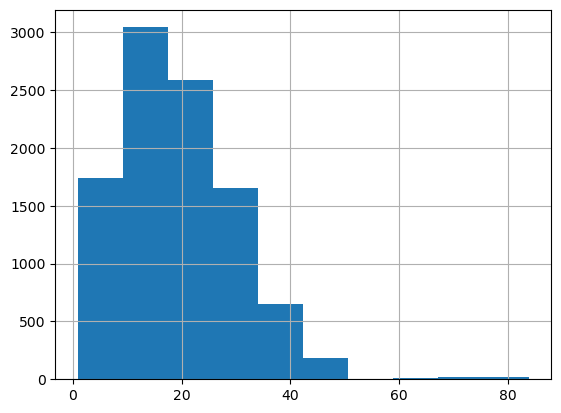

In [ ]:
df_bts_coor_merged['dist_near_w_station'].hist()

<AxesSubplot: >

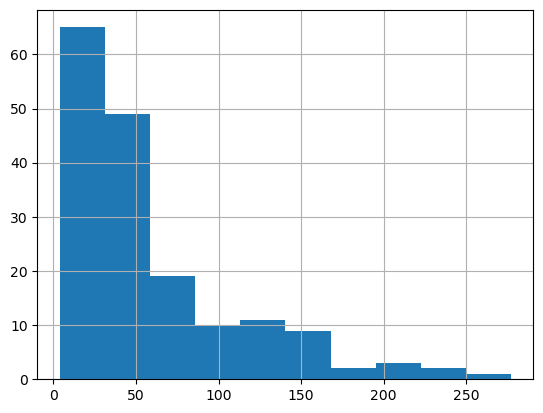

In [ ]:
df_bts_coor_merged['near_w_station'].value_counts().hist()

We see that the assigment went quite okay - most BTS stations are within 50 km of their assigned weather stations, there are few examples above that. Moreover, as we have more BTS stations than weather stations, some weather stations were assigned to more than 250 weather stations. However, it would be hard to avoid such situation, althought it would be interesting to check later, how it corresponds with anomalies.

In [ ]:
# Merging the data - each BTS station we assigned the nearest location of weather station.
# Now, we transfer the corresponding data on the weather to each BTS station.

df_bts_weather = pd.merge(df_bts_coor_merged, df_ws2022d, left_on = 'near_w_station', right_on = 'id', how = 'outer')
df_bts_weather.dropna(subset = ['bts_id'], inplace = True)
df_bts_weather

,bts_id,provider,technology,location,5G,LTE,IOT,GSM,UMTS,long_x,...,B_mean,C_mean,D_mean,E_mean,A_std,B_std,C_std,D_std,E_std,day
0,0.00,Konkurent_2,"[LTE, IOT]",Nowy Wiśnicz,0.00,1.00,1.00,0.00,0.00,20.27,...,-2.54,3.12,2.70,90.47,4.06,4.01,2.86,3.56,11.55,8.95
1,0.00,Konkurent_2,"[LTE, IOT]",Nowy Wiśnicz,0.00,1.00,1.00,0.00,0.00,20.27,...,-0.55,5.01,1.91,84.65,2.77,0.82,0.29,2.70,15.11,8.08
2,0.00,Konkurent_2,"[LTE, IOT]",Nowy Wiśnicz,0.00,1.00,1.00,0.00,0.00,20.27,...,0.22,3.37,1.11,62.74,5.57,5.97,1.57,1.09,24.76,8.94
3,0.00,Konkurent_2,"[LTE, IOT]",Nowy Wiśnicz,0.00,1.00,1.00,0.00,0.00,20.27,...,3.88,3.20,2.62,78.16,4.95,5.27,2.01,3.54,19.15,8.66
4,0.00,Konkurent_2,"[LTE, IOT]",Nowy Wiśnicz,0.00,1.00,1.00,0.00,0.00,20.27,...,12.01,2.51,1.78,66.06,3.76,5.76,1.71,1.96,17.99,8.95
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119011,8889.00,Konkurent_3,"[UMTS, 5G]",Gorlice,1.00,0.00,0.00,0.00,1.00,21.10,...,19.22,1.12,2.58,80.17,5.29,6.64,0.85,7.04,18.80,8.95
119012,8889.00,Konkurent_3,"[UMTS, 5G]",Gorlice,1.00,0.00,0.00,0.00,1.00,21.10,...,12.21,1.03,5.56,87.58,4.51,5.23,0.71,6.01,14.50,8.66
119013,8889.00,Konkurent_3,"[UMTS, 5G]",Gorlice,1.00,0.00,0.00,0.00,1.00,21.10,...,8.54,0.91,2.39,90.82,4.56,4.77,0.65,3.67,12.74,8.95
119014,8889.00,Konkurent_3,"[UMTS, 5G]",Gorlice,1.00,0.00,0.00,0.00,1.00,21.10,...,2.89,0.85,1.82,95.15,4.75,4.63,0.58,4.30,8.09,8.66


In [ ]:
pd.set_option('display.max_columns', None)
df_bts_weather

,bts_id,provider,technology,location,5G,LTE,IOT,GSM,UMTS,long_x,lat_x,near_w_station,dist_near_w_station,index,id,month,name,lat_y,long_y,A_mean,B_mean,C_mean,D_mean,E_mean,A_std,B_std,C_std,D_std,E_std,day
0,0.00,Konkurent_2,"[LTE, IOT]",Nowy Wiśnicz,0.00,1.00,1.00,0.00,0.00,20.27,49.55,49.00,7.39,576,49,1,STUDZIONKI,49.50,20.21,-3.47,-2.54,3.12,2.70,90.47,4.06,4.01,2.86,3.56,11.55,8.95
1,0.00,Konkurent_2,"[LTE, IOT]",Nowy Wiśnicz,0.00,1.00,1.00,0.00,0.00,20.27,49.55,49.00,7.39,577,49,2,STUDZIONKI,49.50,20.21,-0.89,-0.55,5.01,1.91,84.65,2.77,0.82,0.29,2.70,15.11,8.08
2,0.00,Konkurent_2,"[LTE, IOT]",Nowy Wiśnicz,0.00,1.00,1.00,0.00,0.00,20.27,49.55,49.00,7.39,578,49,3,STUDZIONKI,49.50,20.21,0.54,0.22,3.37,1.11,62.74,5.57,5.97,1.57,1.09,24.76,8.94
3,0.00,Konkurent_2,"[LTE, IOT]",Nowy Wiśnicz,0.00,1.00,1.00,0.00,0.00,20.27,49.55,49.00,7.39,579,49,4,STUDZIONKI,49.50,20.21,3.47,3.88,3.20,2.62,78.16,4.95,5.27,2.01,3.54,19.15,8.66
4,0.00,Konkurent_2,"[LTE, IOT]",Nowy Wiśnicz,0.00,1.00,1.00,0.00,0.00,20.27,49.55,49.00,7.39,580,49,5,STUDZIONKI,49.50,20.21,11.77,12.01,2.51,1.78,66.06,3.76,5.76,1.71,1.96,17.99,8.95
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119011,8889.00,Konkurent_3,"[UMTS, 5G]",Gorlice,1.00,0.00,0.00,0.00,1.00,21.10,49.40,293.00,6.65,3415,293,8,TYLICZ,49.39,21.01,17.56,19.22,1.12,2.58,80.17,5.29,6.64,0.85,7.04,18.80,8.95
119012,8889.00,Konkurent_3,"[UMTS, 5G]",Gorlice,1.00,0.00,0.00,0.00,1.00,21.10,49.40,293.00,6.65,3416,293,9,TYLICZ,49.39,21.01,10.46,12.21,1.03,5.56,87.58,4.51,5.23,0.71,6.01,14.50,8.66
119013,8889.00,Konkurent_3,"[UMTS, 5G]",Gorlice,1.00,0.00,0.00,0.00,1.00,21.10,49.40,293.00,6.65,3417,293,10,TYLICZ,49.39,21.01,7.88,8.54,0.91,2.39,90.82,4.56,4.77,0.65,3.67,12.74,8.95
119014,8889.00,Konkurent_3,"[UMTS, 5G]",Gorlice,1.00,0.00,0.00,0.00,1.00,21.10,49.40,293.00,6.65,3418,293,11,TYLICZ,49.39,21.01,2.00,2.89,0.85,1.82,95.15,4.75,4.63,0.58,4.30,8.09,8.66


### Adding the data on BTS malfunctioning

Loading the data from bts_anomalie_pct.xlsx file

In [ ]:
path_bts_anomalies = os.getcwd() + '/data/bts_anomalie_pct.xlsx'

df_bts_anomalies_raw = pd.read_excel(path_bts_anomalies)
df_bts_anomalies_raw

,bts_id,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2022-01,2022-02,2022-03,2022-04,2022-05,2022-06,2022-07,2022-08,2022-09,2022-10,2022-11,2022-12
0,0,0.05,0.11,0.11,0.10,0.08,0.15,0.00,0.10,0.11,0.02,0.10,0.03,0.11,0.05,0.06,0.06,0.05,0.06,0.00,0.04,0.06,0.04,0.11,0.15
1,1,0.15,0.11,0.12,0.12,0.09,0.10,0.12,0.07,0.15,0.06,0.13,0.02,0.10,0.14,0.09,0.12,0.05,0.09,0.06,0.08,0.12,0.14,0.15,0.11
2,2,0.10,0.14,0.07,0.07,0.03,0.10,0.00,0.02,0.13,0.08,0.02,0.10,0.00,0.02,0.13,0.00,0.08,0.00,0.11,0.02,0.15,0.10,0.06,0.13
3,3,0.00,0.02,0.02,0.12,0.00,0.04,0.07,0.11,0.13,0.14,0.02,0.02,0.05,0.11,0.09,0.05,0.10,0.02,0.06,0.13,0.01,0.12,0.05,0.14
4,4,0.15,0.01,0.12,0.14,0.10,0.02,0.12,0.00,0.14,0.00,0.15,0.13,0.09,0.01,0.05,0.13,0.06,0.15,0.03,0.12,0.06,0.10,0.08,0.09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9913,9913,0.15,0.04,0.04,0.07,0.12,0.01,0.13,0.05,0.15,0.03,0.12,0.12,0.02,0.11,0.01,0.05,0.06,0.02,0.10,0.05,0.14,0.05,0.07,0.05
9914,9914,0.13,0.04,0.07,0.10,0.05,0.13,0.04,0.08,0.06,0.11,0.07,0.05,0.01,0.12,0.14,0.08,0.01,0.01,0.11,0.09,0.08,0.09,0.11,0.08
9915,9915,0.14,0.07,0.14,0.15,0.02,0.03,0.09,0.11,0.04,0.15,0.05,0.12,0.04,0.10,0.04,0.14,0.10,0.03,0.14,0.02,0.04,0.13,0.08,0.06
9916,9916,0.09,0.14,0.11,0.11,0.15,0.12,0.08,0.06,0.02,0.01,0.15,0.11,0.09,0.00,0.00,0.05,0.05,0.14,0.11,0.08,0.02,0.13,0.00,0.10


In [ ]:
# Let's focus on the year 2022
df_bts_anomalies_raw = df_bts_anomalies_raw.iloc[:, 13:]

Stacking for easier merging

In [ ]:
anomalies_stacked = df_bts_anomalies_raw.stack()

In [ ]:
df_bts_anomalies = pd.DataFrame(anomalies_stacked)
df_bts_anomalies.reset_index(inplace = True)
df_bts_anomalies.columns = ['bts_id', 'month', 'anomalies']
df_bts_anomalies['month'] = df_bts_anomalies['month'].str.split('-').str[1].astype(int)
df_bts_anomalies

,bts_id,month,anomalies
0,0,1,0.11
1,0,2,0.05
2,0,3,0.06
3,0,4,0.06
4,0,5,0.05
...,...,...,...
119011,9917,8,0.04
119012,9917,9,0.12
119013,9917,10,0.04
119014,9917,11,0.08


In [ ]:
# Checkign NAs
df_bts_anomalies.isna().sum()

bts_id       0
month        0
anomalies    0
dtype: int64

Merging

In [ ]:
df_main = pd.merge(df_bts_weather, df_bts_anomalies, how = 'left', on = ['bts_id', 'month'])

In [ ]:
# Let's delete unnessesary columns and arrange it better

df_main.drop(['technology', 'day', 'index', 'near_w_station'], axis = 'columns', inplace = True)
df_main.rename(columns = {'long_x': 'long_bts', 'lat_x': 'lat_bts', 'lat_y': 'lat_w_station', 'long_y': 'long_w_station', 'id': 'w_station_id', 'location': 'location_bts', 'name': 'location_w_station'}, inplace = True)
df_main = df_main.astype({'bts_id': 'int', '5G': 'bool', 'UMTS': 'bool', 'IOT': 'bool', 'LTE': 'bool', 'GSM': 'bool'})

In [ ]:
# pd.set_option('display.max_columns', None)
df_main

,bts_id,provider,location_bts,5G,LTE,IOT,GSM,UMTS,long_bts,lat_bts,dist_near_w_station,w_station_id,month,location_w_station,lat_w_station,long_w_station,A_mean,B_mean,C_mean,D_mean,E_mean,A_std,B_std,C_std,D_std,E_std,anomalies
0,0,Konkurent_2,Nowy Wiśnicz,False,True,True,False,False,20.27,49.55,7.39,49,1,STUDZIONKI,49.50,20.21,-3.47,-2.54,3.12,2.70,90.47,4.06,4.01,2.86,3.56,11.55,0.11
1,0,Konkurent_2,Nowy Wiśnicz,False,True,True,False,False,20.27,49.55,7.39,49,2,STUDZIONKI,49.50,20.21,-0.89,-0.55,5.01,1.91,84.65,2.77,0.82,0.29,2.70,15.11,0.05
2,0,Konkurent_2,Nowy Wiśnicz,False,True,True,False,False,20.27,49.55,7.39,49,3,STUDZIONKI,49.50,20.21,0.54,0.22,3.37,1.11,62.74,5.57,5.97,1.57,1.09,24.76,0.06
3,0,Konkurent_2,Nowy Wiśnicz,False,True,True,False,False,20.27,49.55,7.39,49,4,STUDZIONKI,49.50,20.21,3.47,3.88,3.20,2.62,78.16,4.95,5.27,2.01,3.54,19.15,0.06
4,0,Konkurent_2,Nowy Wiśnicz,False,True,True,False,False,20.27,49.55,7.39,49,5,STUDZIONKI,49.50,20.21,11.77,12.01,2.51,1.78,66.06,3.76,5.76,1.71,1.96,17.99,0.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119011,8889,Konkurent_3,Gorlice,True,False,False,False,True,21.10,49.40,6.65,293,8,TYLICZ,49.39,21.01,17.56,19.22,1.12,2.58,80.17,5.29,6.64,0.85,7.04,18.80,0.06
119012,8889,Konkurent_3,Gorlice,True,False,False,False,True,21.10,49.40,6.65,293,9,TYLICZ,49.39,21.01,10.46,12.21,1.03,5.56,87.58,4.51,5.23,0.71,6.01,14.50,0.03
119013,8889,Konkurent_3,Gorlice,True,False,False,False,True,21.10,49.40,6.65,293,10,TYLICZ,49.39,21.01,7.88,8.54,0.91,2.39,90.82,4.56,4.77,0.65,3.67,12.74,0.02
119014,8889,Konkurent_3,Gorlice,True,False,False,False,True,21.10,49.40,6.65,293,11,TYLICZ,49.39,21.01,2.00,2.89,0.85,1.82,95.15,4.75,4.63,0.58,4.30,8.09,0.04


In [ ]:
# pd.reset_option('display.max_columns')

We obtained our final dataset with all information intresting for us. Let's save it for further use.

In [ ]:
df_main.to_pickle('df_data_final.pkl')
df_main = pd.read_pickle('df_data_final.pkl')

## Data analysis

At the previous stage, I already adressed the following problems:
- data correctness - I deleted or corrected likely errors in the weather data
- handling missing data - I deleted weather observations where number of missing values was too high; for the rest of observations in filled it in with median parameter values for a particular month. At this point we have no missing data
- handling duplicates - they were deleted
- choosing data scope - our data is aggregated at the month level in term of mean values and standard deviations. I interpret mean monthly values of parameters, for example A_mean as general indicator of the variable for the paricular station and month. I interpret montly standard deviations of parameters, for example A_std as indicator of variability of the variable for the paricular station and month.

Now we can proceed to the data analysis.

### Preliminary analysis for the weather stations data

Taking into account our main goal i.e. analyzing the relationship between the weather and BTS station malfuntioning, we are interested only in the weather data from the weather stations that were "assigned" to one of the BTS stations. We could theoretically analyze all the stations across Poland and the results would be probably similiar, but for clarity let's focus only on weather stations assigned to BTS stations.

At some points during preprocessing we already calculated basic statistics and correlations, but let's do it again for the weather data in the final dataset.

(*I am aware that after aggregation, we obtained montly means and stds based on separate hour values i.e. our raw data. Now, we will be calulaing for example, mean of those means which probably won't be exactly equal to the mean which could be calculated based on observations for separate hours, the same for standard deviations etc.). However, I treat it as good enough approximation for later analysis and those variables still have explanotary power*).

Exctracting the weather data from the main file, so that we do not count duplicate stations as separate observations.

In [ ]:
df_weather = df_main.drop_duplicates(subset = ['w_station_id', 'month']).reset_index(drop = True).iloc[:, 11:]
df_weather

,w_station_id,month,location_w_station,lat_w_station,long_w_station,A_mean,B_mean,C_mean,D_mean,E_mean,A_std,B_std,C_std,D_std,E_std,anomalies
0,49,1,STUDZIONKI,49.50,20.21,-3.47,-2.54,3.12,2.70,90.47,4.06,4.01,2.86,3.56,11.55,0.11
1,49,2,STUDZIONKI,49.50,20.21,-0.89,-0.55,5.01,1.91,84.65,2.77,0.82,0.29,2.70,15.11,0.05
2,49,3,STUDZIONKI,49.50,20.21,0.54,0.22,3.37,1.11,62.74,5.57,5.97,1.57,1.09,24.76,0.06
3,49,4,STUDZIONKI,49.50,20.21,3.47,3.88,3.20,2.62,78.16,4.95,5.27,2.01,3.54,19.15,0.06
4,49,5,STUDZIONKI,49.50,20.21,11.77,12.01,2.51,1.78,66.06,3.76,5.76,1.71,1.96,17.99,0.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2047,293,8,TYLICZ,49.39,21.01,17.56,19.22,1.12,2.58,80.17,5.29,6.64,0.85,7.04,18.80,0.00
2048,293,9,TYLICZ,49.39,21.01,10.46,12.21,1.03,5.56,87.58,4.51,5.23,0.71,6.01,14.50,0.15
2049,293,10,TYLICZ,49.39,21.01,7.88,8.54,0.91,2.39,90.82,4.56,4.77,0.65,3.67,12.74,0.15
2050,293,11,TYLICZ,49.39,21.01,2.00,2.89,0.85,1.82,95.15,4.75,4.63,0.58,4.30,8.09,0.06


**Basic statistics** of weather variables and BTS malfunctioning (anomalies) across all months and all BTS stations

In [ ]:
df_weather.iloc[:, 4:].describe()

,long_w_station,A_mean,B_mean,C_mean,D_mean,E_mean,A_std,B_std,C_std,D_std,E_std,anomalies
count,2052.00,2052.00,2052.00,2052.00,2052.00,2052.00,2052.00,2052.00,2052.00,2052.00,2052.00,2052.00
mean,19.31,9.01,9.89,2.94,2.12,77.13,4.63,5.53,1.58,3.36,16.33,0.07
std,2.42,7.17,7.61,1.36,1.22,9.79,0.93,1.57,0.58,2.44,5.06,0.05
min,14.24,-5.84,-6.34,0.50,0.37,36.60,0.27,0.29,0.28,0.21,3.29,0.00
25%,17.39,2.68,3.00,2.16,1.31,69.20,4.10,4.48,1.21,1.82,11.81,0.03
50%,19.60,7.74,8.51,2.76,1.87,77.22,4.77,5.52,1.48,2.76,17.59,0.07
75%,21.05,14.91,16.18,3.45,2.59,85.53,5.23,6.75,1.83,4.27,20.75,0.11
max,23.85,23.21,25.09,28.09,12.92,98.13,10.23,17.72,5.97,23.78,40.10,0.15


Looking at the basic statistics, we can also see high correlation or likeliness between A and B parameters. Values of all parameters seem quite likely in terms of correspondence with real life.

Now let's look at the **Pearson correlations** for the weather variables (numerical).

In [ ]:
corr = df_weather.iloc[:, 4:].corr()
corr.style.background_gradient(cmap = 'coolwarm', axis=None)

,long_w_station,A_mean,B_mean,C_mean,D_mean,E_mean,A_std,B_std,C_std,D_std,E_std,anomalies
long_w_station,1.000000,-0.048590,-0.041511,-0.158837,0.092678,0.051130,0.024487,0.013308,-0.128143,0.069040,-0.018643,-0.017325
A_mean,-0.048590,1.000000,0.994832,-0.291811,0.301303,-0.453615,0.378345,0.619746,-0.274316,0.459952,0.565343,0.008983
B_mean,-0.041511,0.994832,1.000000,-0.297063,0.311309,-0.443933,0.387927,0.616634,-0.280087,0.469964,0.555909,0.007142
C_mean,-0.158837,-0.291811,-0.297063,1.000000,-0.136617,0.097049,-0.418254,-0.347528,0.828488,-0.173947,-0.194991,-0.026874
D_mean,0.092678,0.301303,0.311309,-0.136617,1.000000,0.095305,-0.113611,-0.044464,-0.145547,0.878610,0.065006,0.002720
E_mean,0.051130,-0.453615,-0.443933,0.097049,0.095305,1.000000,-0.419972,-0.637505,0.012369,-0.036320,-0.831644,0.006477
A_std,0.024487,0.378345,0.387927,-0.418254,-0.113611,-0.419972,1.000000,0.791536,-0.366900,0.051953,0.466772,-0.006141
B_std,0.013308,0.619746,0.616634,-0.347528,-0.044464,-0.637505,0.791536,1.000000,-0.283509,0.132708,0.689122,0.025566
C_std,-0.128143,-0.274316,-0.280087,0.828488,-0.145547,0.012369,-0.366900,-0.283509,1.000000,-0.191553,-0.098919,0.005782
D_std,0.069040,0.459952,0.469964,-0.173947,0.878610,-0.036320,0.051953,0.132708,-0.191553,1.000000,0.191119,0.003822


As we are anlyzing the weather data, we see some obvious relationships between variables. Most of them could be probably explained by science, if one is a weather expert. For example, wind conditions and humidity are generally dependend on the temperature and pressure of the system. At the first glance, we see very high positive linear correlations between A (air temperature) and B (ground temperature) variables, both between their mean values and between their standard deviations (which is of course expected). For stds, we have high negative correlation for B_std and E_std, which is interesting. The rest of stds are not that significantly correlated. For the rest, correlations are not that strong.

Moreover, there are quite significant correlations between a particular variable mean and its standard deviation. Although under normal distribution, mean and standard deviation should be independent, here we observe that for variables A, B, C and D the higher the value of the parameter in a particular month, the higher its variability. For variable E it is the opposite.

Unfortunately, all analyzed variables are not at all linearly correlated with percent of anomalies, which is our target variable. It suggest that doing simple linear regression on weather variables to predict the anomalies might not be sufficient. However, we still not taken into account categorical variables, such as months or stations itself.


Now let's look at **mean air temperature and its variability** across the months at the level of Poland (all BTS stations).

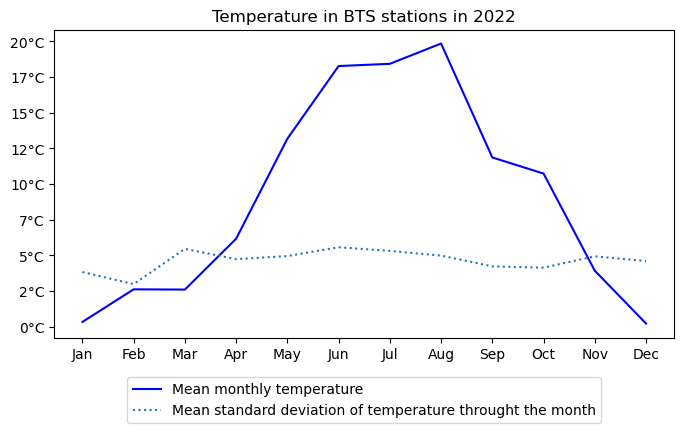

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import calendar

month_labels = [calendar.month_abbr[x] for x in range(1, 13)]

pom = df_weather.groupby('month').mean(numeric_only = True)

fig, ax = plt.subplots(figsize=(8, 4))
plt.plot(month_labels, pom['A_mean'], label = "Mean monthly temperature", color = 'blue')
plt.plot(month_labels, pom['A_std'], label = "Mean standard deviation of temperature throught the month", linestyle = 'dotted')
plt.gca().yaxis.set_major_formatter(mticker.FormatStrFormatter('%d°C'))
plt.title("Temperature in BTS stations in 2022")
plt.legend(loc = 'lower center', bbox_to_anchor=(0.5, -0.3))
plt.show()

According to expectations, we see the highest montly mean temperatures of around 18-20°C in summer months: August, July and June. On the other hand, the lowest temperatures of 0°C we have in winter months: January and December. Mean standard deviation of temperatures are pretty constant throught the year and are of around 3-5°C.

Now let's look at mean **wind speed and total daily percipitation** across the months at the Poland level (all BTS stations).

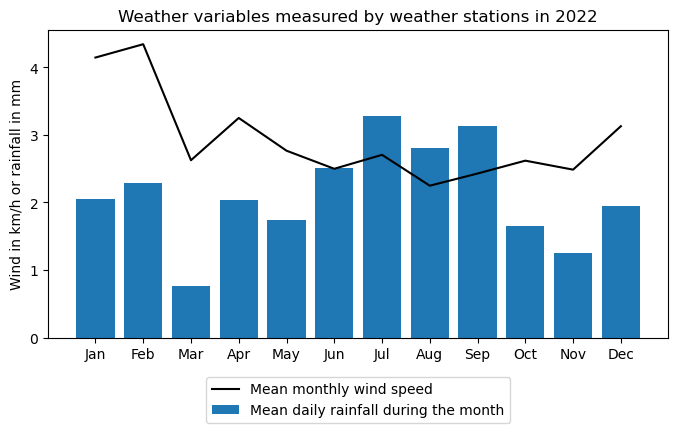

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4))
plt.plot(month_labels, pom['C_mean'], label = "Mean monthly wind speed", color = 'black')
plt.bar(month_labels, pom['D_mean'], label = "Mean daily rainfall during the month")
plt.ylabel("Wind in km/h or rainfall in mm") # Założyłam jednostki
plt.title("Weather variables measured by weather stations in 2022")
plt.legend(loc = 'lower center', bbox_to_anchor=(0.5, -0.3))
plt.show()

We see the highest daily percipitation in July and September and the lowest in March. The wind is the strongest in winter, in January and February.

### Preliminary analysis for the BTS stations data

Let's focus now on the BTS stations data.

<AxesSubplot: title={'center': 'Number of BTS stations by provider'}>

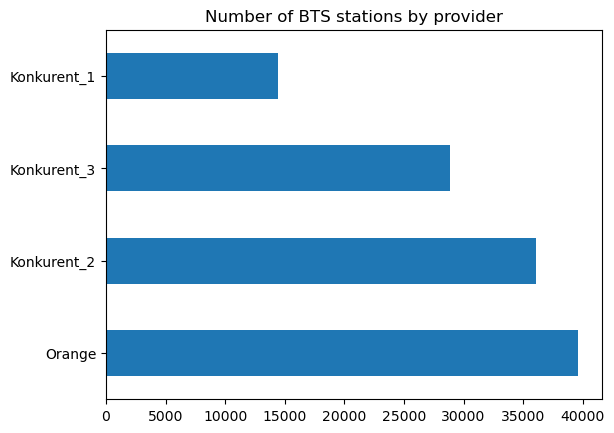

In [ ]:
df_main.provider.value_counts().plot(kind = 'barh', title = 'Number of BTS stations by provider')

Text(0.5, 1.0, 'Percentage of all BTS stations using particular technology')

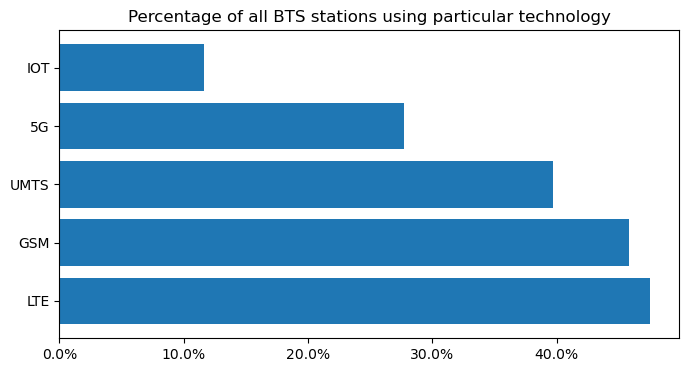

In [ ]:
import matplotlib.ticker as mtick

fig, ax = plt.subplots(figsize=(8, 4))

technologies = ['LTE', 'GSM', 'UMTS', '5G', 'IOT']
percentages = [(df_main[technology].value_counts(normalize = True) * 100)[1] for technology in technologies]

plt.barh(technologies, percentages)
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter())
plt.title("Percentage of all BTS stations using particular technology")

Also, let's look at the distribution of BTS failure rates.

Text(0.5, 1.0, 'Distribution of percentage of anomalies across BTS stations')

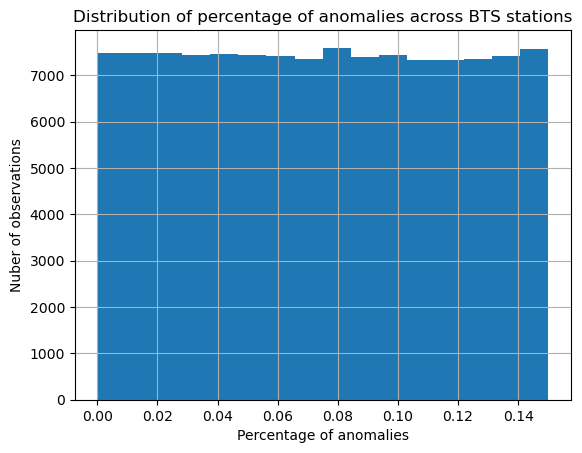

In [ ]:
df_main.anomalies.hist(bins = 16)
plt.xlabel('Percentage of anomalies')
plt.ylabel('Nuber of observations')
plt.title('Distribution of percentage of anomalies across BTS stations')

Well, as it was said, the data was generated randomly which could probably explain the uniform distribution of anomalies. All the possible values range from 0.00 to 0.15 by 0.01. In real life, one would probably expect something more normal looking, for example that a high rates of anomalies would be less frequent.

We can also check if generally anomalies could be dependent on the month using one-way ANOVA, but we see that they are not.

In [ ]:
anomalies_by_month = df_main[['month', 'anomalies']]

anova_abm = stats.f_oneway(*[group['anomalies'] for name, group in anomalies_by_month.groupby('month')])
print(anova_abm.pvalue)

# P-value is much higher than 0.05 so we cannot reject the null hypothesis that the mean values of anomalies are statistically equal across the months.

0.8643288094914362


### Comparing Orange and other providers

Let's compare anomalies for Orange stations and its competitors.

In [ ]:
providers = df_main.drop(['bts_id', 'long_bts', 'lat_bts', 'month', 'w_station_id'], axis = "columns").groupby('provider').mean()
providers['bts_id_count'] = df_main.provider.value_counts()
providers

# The table is pretty straightfoward, so I feel no need to visualize it.

,5G,LTE,IOT,GSM,UMTS,dist_near_w_station,lat_w_station,long_w_station,A_mean,B_mean,C_mean,D_mean,E_mean,A_std,B_std,C_std,D_std,E_std,anomalies,bts_id_count
provider,,,,,,,,,,,,,,,,,,,,
Konkurent_1,0.30,0.54,0.12,0.44,0.40,19.31,51.67,18.73,9.45,10.28,2.99,2.00,76.30,4.67,5.60,1.58,3.20,16.55,0.08,14460
Konkurent_2,0.28,0.52,0.12,0.46,0.39,19.58,51.65,18.73,9.40,10.22,2.98,2.02,76.48,4.68,5.61,1.58,3.24,16.57,0.07,36048
Konkurent_3,0.27,0.52,0.12,0.46,0.40,19.30,51.64,18.82,9.37,10.20,2.99,2.02,76.43,4.68,5.59,1.59,3.24,16.57,0.07,28872
Orange,0.27,0.52,0.11,0.46,0.40,19.18,51.65,18.76,9.43,10.24,2.97,2.01,76.43,4.69,5.62,1.57,3.22,16.57,0.07,39636


Looking at the table, we can see that all providers have, in fact, very similiars networks in distributions of technologies they use and weather conditions at the stations.

### Identification of stations that are exposed to the most extreme weather changes

As I aggregated data on the monthly levels, we will focus on those statistics; however, I acklowledge that it could be also beneficial to have the data at lower level of aggregation, for example to check the number of separate extreme weather events throught the month that usually last few hours. Still, as standard deviation was calculated based on those raw single observation on the level of hours, we have some information preserved. I am focusing here on standard deviation as an indicator of weather changes/its variability.

Here I am first identifing **weather stations** among those assigned to BTS, so using the df_weather dataframe. As was showned before, each weather station can have up to 250 BTS stations assigned to it.

In [ ]:
# The stations with largest A_std are actually the same as the largest variations in B_std

top3_AB_std = df_weather.nlargest(3, 'A_std')
top3_AB_std

,w_station_id,month,location_w_station,lat_w_station,long_w_station,A_mean,B_mean,C_mean,D_mean,E_mean,A_std,B_std,C_std,D_std,E_std,anomalies
90,470,7,CHRZĽSTOWO,53.16,17.58,20.49,22.25,3.80,0.72,65.96,10.23,11.11,1.89,1.48,20.95,0.13
1721,388,6,CIESZANÓW,50.23,23.12,20.09,21.82,2.61,1.56,67.37,8.46,9.18,1.59,2.84,21.99,0.12
89,470,6,CHRZĽSTOWO,53.16,17.58,18.13,19.69,3.42,1.53,67.08,8.10,8.80,1.85,3.33,20.99,0.02


In [ ]:
top3_C_std = df_weather.nlargest(3, 'C_std')
top3_C_std
# The largest variation is for Śnieżka which could be explained by its special location in the mountains.

,w_station_id,month,location_w_station,lat_w_station,long_w_station,A_mean,B_mean,C_mean,D_mean,E_mean,A_std,B_std,C_std,D_std,E_std,anomalies
1715,149,12,NIEŻKA,50.74,15.74,-4.87,-5.29,12.61,1.68,85.88,4.73,5.14,5.97,2.54,21.34,0.09
1713,149,10,NIEŻKA,50.74,15.74,5.73,6.22,11.81,1.00,83.10,4.04,4.39,5.57,1.51,24.37,0.03
1712,149,9,NIEŻKA,50.74,15.74,4.08,4.44,9.29,2.97,96.68,3.96,4.30,5.18,4.45,6.93,0.07


In [ ]:
top3_D_std = df_weather.nlargest(3, 'D_std')
top3_D_std

,w_station_id,month,location_w_station,lat_w_station,long_w_station,A_mean,B_mean,C_mean,D_mean,E_mean,A_std,B_std,C_std,D_std,E_std,anomalies
764,136,9,GORZÓW WIELKOPOLSKI,52.74,15.28,13.45,14.40,2.89,6.02,73.62,4.18,5.25,1.21,23.78,19.28,0.10
871,133,8,OPOLE,50.63,17.97,20.74,22.31,2.32,9.40,74.38,5.09,5.96,1.10,22.64,21.41,0.04
1338,192,7,GOŁDAP,54.31,22.27,17.16,20.29,2.73,5.41,79.85,4.54,7.11,1.39,20.41,17.77,0.14


Now let's get all BTS stations that are assigned to one of the above weather stations identified as those with the highest variability of weather variables. We see that we have quite a lot of those stations.

In [ ]:
weather_changes_stations = list(set(top3_AB_std['w_station_id'].to_list() + top3_C_std['w_station_id'].to_list() + top3_D_std['w_station_id'].to_list() ))

filtered_data = df_main[df_main['w_station_id'].isin(weather_changes_stations)]
bts_ids_weather_changes = list(set(filtered_data['bts_id']))
print(*bts_ids_weather_changes)

2051 5123 5125 9222 7 6152 5129 3083 8203 2065 1553 9745 7700 5142 9750 6169 9242 1563 7195 1565 7710 8219 9760 4647 7720 9768 8234 5163 4651 7213 3630 9259 9264 9777 5677 4148 5173 8245 6710 3639 4661 4154 9270 573 7742 3648 5185 2114 3140 4677 582 3143 1092 2635 5196 6733 589 9805 4176 9809 2643 2644 7768 6232 3162 9819 7772 3677 3166 95 1120 4703 8799 1637 7781 7271 7782 8298 6252 9837 5230 7792 7793 7797 119 8312 6776 9853 7294 2691 5252 3716 4229 1159 8327 2697 9354 8846 5775 6800 4753 6801 7828 4757 7830 9367 7320 2201 3732 7323 9371 156 7840 8352 9378 7844 7333 6824 4266 8367 7857 693 7862 5307 2748 707 6851 6856 6347 2764 2763 3789 8911 7373 7889 5333 726 7381 2263 729 3289 4313 5340 7894 4318 4320 7395 742 9446 5350 5866 6378 748 237 1773 3306 5873 6386 8435 5876 9461 6390 1782 5368 4351 258 2819 5891 8967 8973 7950 272 7440 6418 3346 8465 8981 8977 2839 5914 8477 4384 8993 802 6944 1828 4390 5414 4904 2344 3368 9514 4396 5933 9006 6447 9010 9524 6452 6967 9530 2370 3395 6982 

### Visualization of stations on the map

Loading the map of Poland with voivodeships borders. I downloaded the shapefile from https://gis-support.pl/baza-wiedzy-2/dane-do-pobrania/granice-administracyjne/

In [ ]:
import geopandas as gpd

path = os.getcwd() + '\wojewodztwa\wojewodztwa.shp'

polska = gpd.read_file(path).to_crs(epsg = 4326)
polska.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Connecting the points from our dataframe to points on the map

In [ ]:
df_main_bts = df_main.copy()
df_main_ws = df_main.copy()

In [ ]:
from shapely.geometry import Point

geometry_bts = [Point(xy) for xy in zip(df_main_bts['long_bts'], df_main_bts['lat_bts'])]
geo_df_bts = gpd.GeoDataFrame(df_main_bts, geometry = geometry_bts, crs = 'epsg:4326')

geometry_w_station = [Point(xy) for xy in zip(df_main_ws['long_w_station'], df_main_ws['lat_w_station'])]
geo_df_w_station = gpd.GeoDataFrame(df_main_ws, geometry = geometry_w_station, crs= 'epsg:4326')

Now, let's visualize everything on the maps

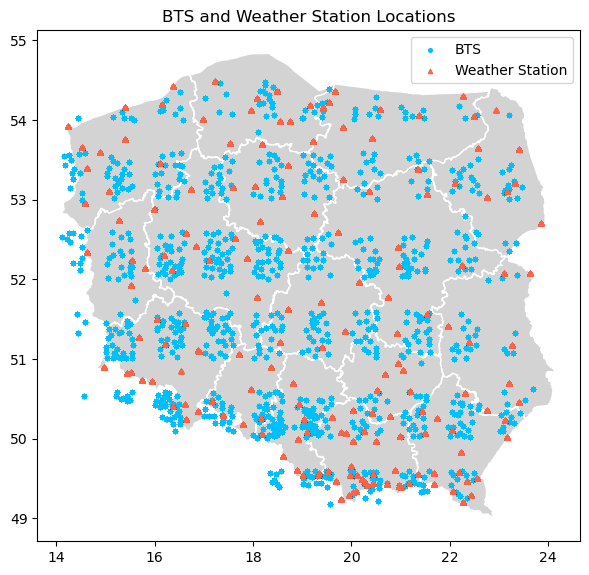

In [ ]:
fig, ax = plt.subplots(figsize = (7, 7))

polska.plot(ax = ax, color = 'lightgrey', edgecolor='white', linewidth=1)

geo_df_bts.plot(ax = ax, color = 'deepskyblue', marker = 'o', markersize = 7, label = 'BTS')
geo_df_w_station.plot(ax = ax, color = 'tomato', marker = '^', markersize = 9, label = 'Weather Station')

ax.set_title('BTS and Weather Station Locations')
ax.legend()

plt.show()

We see that the BTS stations are actually grouped in quite visible groups. Also we see some locations even outside Poland. Let's remind that this are locations whose coordinates we had to map ourself using city names. This might be due to artificial generation of data, actual BTS stations characteristics or - I hope not because I have checked it - possible problems with mapping :)

On the other hand, weather stations seems to be placed at random. However, let's remind that during the initial phrase we dropped almost half of weather stations due to insufficient data, and then some of the remaining weather station might have not been used as they were not close to any BTS station. So we do not know the initial distribution of those stations across the map.

Let's also try to visualize some weather parameters. For example, let's visualize which weather station experience the highest temperatures during August (the warmest month).

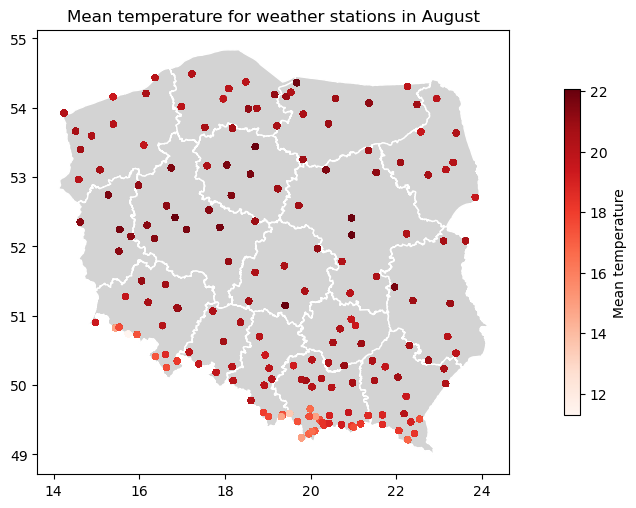

In [ ]:
import matplotlib.colors as mcolors

fig, ax = plt.subplots(figsize=(7, 7))
polska.plot(ax = ax, color='lightgrey', edgecolor = 'white', linewidth = 1)

df_month_8 = df_main[df_main['month'] == 8]

max_a_mean_month_8 = df_month_8.groupby('w_station_id')['A_mean'].max()
geo_df_w_station = geo_df_w_station.merge(max_a_mean_month_8, left_on='w_station_id', right_index=True, suffixes=('', '_max'))

# Plot Weather Stations with colors based on A_mean_max
cmap = plt.cm.get_cmap('Reds')
normalize = mcolors.Normalize(vmin=geo_df_w_station['A_mean_max'].min(), vmax=geo_df_w_station['A_mean_max'].max())
colors = [cmap(normalize(value)) for value in geo_df_w_station['A_mean_max']]

geo_df_w_station.plot(ax = ax, color = colors, marker = 'o', markersize = 14)

# Creating custom color map legend
sm = plt.cm.ScalarMappable(cmap = cmap, norm = normalize)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, orientation = 'vertical', fraction = 0.03, pad = 0.1)
cbar.set_label('Mean temperature')

ax.set_title('Mean temperature for weather stations in August')
plt.show()

### Assesing the impact of weather on BTS malfunctioning

In [ ]:
# Splitting the dataset into dependent and independ variables

X = df_main[['bts_id', 'month', 'UMTS', 'IOT', 'LTE', '5G', 'GSM', 'A_mean', 'C_mean', 'D_mean', 'E_mean', 'A_std', 'C_std', 'D_std', 'E_std']].set_index(['bts_id', 'month']) #Not including B
X = pd.get_dummies(data = X, columns = ['UMTS', 'IOT', 'LTE', '5G', 'GSM'], drop_first = True)
Y = df_main['anomalies']

In this project we are dealing with the panel data which means that we have multiple units which we observe at multiple points in time. From the statistical perpective, panel data could be harder to deal with due to autocorrelation of errors from the time dimension. Therefore, it is better to use regressions models specifically dedicated to panel data.

There are three main panel data models: pooled OLS, fixed effects and random effects.

Let's start with **pooled OLS** which is the most basic one and corresponds to standard OLS, just done on the panel data.

In [ ]:
df_panel = df_main[['bts_id', 'month', 'UMTS', 'IOT', 'LTE', '5G', 'GSM', 'A_mean', 'C_mean', 'D_mean', 'E_mean', 'A_std', 'C_std', 'D_std', 'E_std', 'anomalies']].set_index(['bts_id', 'month'])
df_panel = pd.get_dummies(data = df_panel, columns = ['UMTS', 'IOT', 'LTE', '5G', 'GSM'], drop_first = True)

months = df_panel.index.get_level_values('month').to_list()
df_panel['months'] = pd.Categorical(months)

In [ ]:
from linearmodels import PooledOLS
import statsmodels.api as sm

X = df_panel.loc[:, df_panel.columns != "anomalies"]
X = sm.add_constant(X)
Y = df_panel['anomalies']

mod = PooledOLS(Y, X)
pooledOLS_res = mod.fit(cov_type = 'clustered', cluster_entity=True)

# Store values for checking homoskedasticity graphically
fittedvals_pooled_OLS = pooledOLS_res.predict().fitted_values
residuals_pooled_OLS = pooledOLS_res.resids

Now let's check whether this model is correct. For Pooled OLS to be correct we have to have:
- homoskedasticity of errors (constant variance)
- no autocorrelations of erros (no correlations between errors in different terms)

Let's check homoskedasticity first using visualization and statistical tests

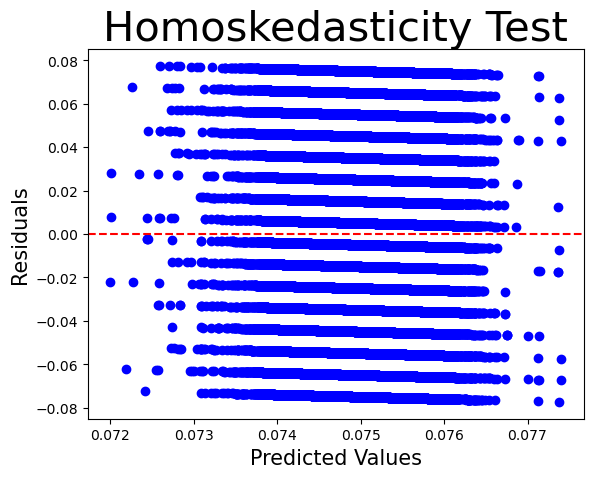

In [ ]:
# Plotting errors for visual inspection

import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.scatter(fittedvals_pooled_OLS, residuals_pooled_OLS, color = 'blue')
ax.axhline(0, color = 'r', ls = '--')
ax.set_xlabel('Predicted Values', fontsize = 15)
ax.set_ylabel('Residuals', fontsize = 15)
ax.set_title('Homoskedasticity Test', fontsize = 30)
plt.show()

# Errors seems to be equally distributed (as equal as generated data can be)

In [ ]:
# Now let's check homoskedasticity using the formal tests

from statsmodels.stats.diagnostic import het_white, het_breuschpagan

# White-Test
white_test_results = het_white(pooledOLS_res.resids, X)
labels = ['LM-Stat', 'LM p-val', 'F-Stat', 'F p-val']
print(dict(zip(labels, white_test_results)))

# Breusch-Pagan-Test
breusch_pagan_test_results = het_breuschpagan(pooledOLS_res.resids, X)
print(dict(zip(labels, breusch_pagan_test_results)))

# In both tests p-value is higher than 0.05 -> we cannot reject the null hypothesis that errors are homoskedastic

{'LM-Stat': 128.74769677690543, 'LM p-val': 0.16324613669521887, 'F-Stat': 1.1294963570195204, 'F p-val': 0.16315856587003874}
{'LM-Stat': 16.976092467387545, 'LM p-val': 0.2574541399046974, 'F-Stat': 1.2125981694014354, 'F p-val': 0.25745804484051016}


Let's also check the autocorrelation using Durbin-Watson test

In [ ]:
from statsmodels.stats.stattools import durbin_watson

# Durbin-Watson test
durbin_watson_test_results = durbin_watson(pooledOLS_res.resids)
print(durbin_watson_test_results)

# The value of Durbin-Watson test is very close to 2 which suggests no autocorrelation

1.9946302020119013


Suprisingly, we found that the Pooled OLS model fulfill approriate assumptions. Suprisingly because it is very hard to fullfill these assumptions on real-world data, but here it can be explained since the data was generated. Therefore, our Pooled OLS is correct and could derive statistical inference. It could be beneficial to compare Pooled OLS also with other models (fixed and random effects) but due to lack of time, let's stick with that.

Let's check the summary.

In [ ]:
print(pooledOLS_res)

                          PooledOLS Estimation Summary                          
Dep. Variable:              anomalies   R-squared:                        0.0001
Estimator:                  PooledOLS   R-squared (Between):              0.0006
No. Observations:              119016   R-squared (Within):            8.069e-05
Date:                Thu, Nov 16 2023   R-squared (Overall):              0.0001
Time:                        12:34:42   Log-likelihood                 1.972e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      0.6139
Entities:                        9918   P-value                           0.9283
Avg Obs:                       12.000   Distribution:               F(24,118991)
Min Obs:                       12.000                                           
Max Obs:                       12.000   F-statistic (robust):             0.6103
                            

It seems that all the variables are actually insignificant! They all have p-values greater than 0.05, and much greater in most cases. This also includes all weather variables. We have seen from the correlation table that, in fact, there are little linear relationship between them and the anomalies. However, I still hoped than when controlling for other variables, some relationship could become prominent.

In this case we might try to also add square roots of weather variables - maybe anomalies are more prominent in extreme weather?

In [ ]:
# Adding square roots of variables

# I tried to did that code but got error "exog does not have full column rank" which suggest that the created columns were linear combiantions of other coluns

# columns_to_square = ['A_mean', 'C_mean', 'D_mean', 'E_mean']
# X2 = sm.add_constant(X.assign(**{f'{col}^2': lambda x: x[col] ** 2 for col in columns_to_square}))

X['A_mean2'] = X['A_mean']**2
# I also tried other variables separately, but only A was stastically significant

In [ ]:
# Building a new model

mod2 = PooledOLS(Y, X)
pooledOLS_res2 = mod2.fit(cov_type = 'clustered', cluster_entity=True)

# I do present here checking the assumptions once again as the data has not changed that much. All assumptions still hold.

In [ ]:
print(pooledOLS_res2)

                          PooledOLS Estimation Summary                          
Dep. Variable:              anomalies   R-squared:                        0.0002
Estimator:                  PooledOLS   R-squared (Between):              0.0006
No. Observations:              119016   R-squared (Within):               0.0002
Date:                Thu, Nov 16 2023   R-squared (Overall):              0.0002
Time:                        12:34:45   Log-likelihood                 1.972e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      0.9517
Entities:                        9918   P-value                           0.5313
Avg Obs:                       12.000   Distribution:               F(25,118990)
Min Obs:                       12.000                                           
Max Obs:                       12.000   F-statistic (robust):             0.9428
                            

We see that only the air temperature (variable A) and its square root is significant with p-values below 0.05 (as mentioned in the comments, I also tested adding square roots of other variables but they were insignificant). However, its coefficient is very small which suggests that still, temperature does not affect anomalies in any significant way. Also, the April (months.4) variable became significant, but at the margin (0.0489) and in previous regression it was pretty insignificant, so I would say this is within statistical error. Moreover, the R^2 of the model is very small as well.

To sum up, based on the pooled OLS models I assess that **the weather (and other variables, such as months or technology) have no relationship with anomalies in BTS stations** (I am using pooled OLS so from the stastical perpective I cannot say anything about the casual relationship between those variables).

## Training machine learning models

### Clustering - identification of weather stations with similiar conditions

As I mentioned before, each weather station has assigned multiple BTS stations. Therefore, clustering BTS stations based on weather conditions would be quite poitless, as obviously all BTS stations which were assigned the same weather stations would be clustered together.

This is why I decided to cluster only the weather stations. If it would be neccesary, one can easily extract BTS stations assigned to weather stations in each cluster. Although we are losing the data on anomalies, well - as we have seen before there is little relationship between the weather and anomalies.

#### Preparing the data

In [ ]:
# We are using the dataframe df_weather created earlier. Let's unstack it and create new variables for each month.

df_weather_clus_pom = df_weather.drop(['location_w_station', 'lat_w_station', 'long_w_station', 'anomalies'], axis = 1)

df_weather_clus = df_weather_clus_pom.pivot(index = ['w_station_id'], columns = ['month'])
df_weather_clus.columns = ['_'.join(map(str, col)).strip() for col in df_weather_clus.columns.values]
df_weather_clus.reset_index(inplace=True)

df_weather_clus

In [ ]:
# Let's select the features

X = df_weather_clus.iloc[:, 1:]

In [ ]:
# Let's normalize them

from sklearn import preprocessing

std_scale = preprocessing.StandardScaler().fit(X)
X = std_scale.transform(X)
normalized_X = pd.DataFrame(X, columns = df_weather_clus.iloc[:, 1:].columns)

By unstacking monthly data we have obtained looots of features. I tried to reduce their number, but correlations between them were not obvious. Additionaly, when I tried the PCA, I got that

We need to reduce the number of features.

In [ ]:
corr_clus = normalized_X.corr()
corr_clus.style.background_gradient(cmap = 'coolwarm', axis=None)

# Briefly looking at this large matrix we see that unfortunately not all variables are correlated with each other across one
# variable type (so for example E_std_10 and E_std_8 have quite low correlation)

Here I tried to do the PCA. However, I am not sure why

In [ ]:
from sklearn.decomposition import PCA

exp_var = []

for k in range(2, 20):

    pca = PCA(n_components = k)
    pca_features = pca.fit_transform(normalized_X)

    exp_var.append(pca.explained_variance_ratio_.cumsum()[-1:])

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 20).fit(normalized_X)

plt.rcParams["figure.figsize"] = (8,5)

fig, ax = plt.subplots()
xi = np.arange(1, 21, step = 1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0, 1.1)
plt.plot(xi, y, marker='o', linestyle='-', color='black')

plt.xlabel('Number of Components')
plt.xticks(np.arange(1, 21, step=1))
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='grey', linestyle='--')
plt.text(1.1, 1, '95% cut-off threshold', color = 'black', fontsize=16)

ax.grid(axis='x')
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

kmeans_kwargs = {"init": "random", "n_init": 10, "max_iter": 300, "random_state": 42}

sse = []
silhouette_coefficients = []

for k in range(2, 15):

    kmeans = KMeans(n_clusters = k, **kmeans_kwargs)
    kmeans.fit(normalized_X)

    sse.append(kmeans.inertia_)

    score = silhouette_score(normalized_X, kmeans.labels_)
    silhouette_coefficients.append(score)

Let's see how many clusters we should choose.

In [ ]:
# Plotting bthe SSE to check the optimal number of clusters

plt.plot(range(2, 15), sse)
plt.xticks(range(2, 15))
plt.xlabel("Number of Clusters")
plt.ylabel("Sum of Square Error (SSE)")
plt.show()

In [ ]:
# Chceking also the optimal number of clusters using the silhouette score

plt.plot(range(2, 15), silhouette_coefficients)
plt.xticks(range(2, 15))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

Based on the SSE graph, there is no that much clear elbow visible. However, I would say that 7 clusters is a nice point where the SSE stops decreasing so rapidly.

On the other hand, looking at the silhouette coeddicient graph, we see that our assigment into groups is not good. Low coefficient values, close to 0 suggest that the clusters are not that different and might be overlapping. We should be looking at the higherst possible silhouette scores. For previously chosen 7 clusters the value is very low but still better than for most of other cluster numbers. 4 clusters, on the other hand which have the highest silhouette score after 2, are not so great based on elbow method.

This is why I would stick with 7 clusters for K-Means.

In [ ]:
kmeans = KMeans(n_clusters = 7, **kmeans_kwargs)
kmeans.fit(normalized_X)
df_weather_clus['k_means_7'] = kmeans.labels_

Let's visualize clusters on the map.

### Classification model predicting a high percentage of anomaly occurences

In this part I will try to predict if a particular BTS station will experience a high percentage anomalies. I will do it based on the weather and station data.

In the Data Analysis section we already took a look at the distribution of anomalies. As a cut-of point for classifying a percentage of anomalies as high I have chosen 0.14 which is the 94th quantile. This means that I consider the 6% of the highest percentages of anomalies as a high anomaly occurence.

#### Preparing the data

In [ ]:
# from scipy import stats

# stats.percentileofscore(df_main['anomalies'], 0.14)
# df_main['anomalies'].quantile(0.9)

In [ ]:
df_main['high_anomaly'] = np.where(df_main['anomalies'] > 0.14, 1, 0)
df_main['high_anomaly'].value_counts(normalize = True)

I already checked the correlation between variables in the previous steps. However, it was not very helpful. I could do a PCA for better feature selection, but due to the lack of time, I just stick with the original dataset and I only did not include B_mean and B_std due to its high correlation with A_mean and A_std.

In [ ]:
X = df_main[['A_mean', 'C_mean', 'D_mean', 'E_mean', 'A_std', 'C_std', 'D_std', 'E_std', 'UMTS', 'IOT', 'LTE', '5G', 'GSM', 'month']] # Not including B
X = pd.get_dummies(data = X, columns = ['UMTS', 'IOT', 'LTE', '5G', 'GSM', 'month'], drop_first = True)
Y = df_main['high_anomaly']

In [ ]:
# Splitting the data into training and testing samples so that proportion of positive and negatives are rouhly the same in each sample.

from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, stratify = Y, random_state = 12345)

In [ ]:
# Normalizing the data

from sklearn import preprocessing

num_cols = X_train.iloc[:, :8].columns

std_scale = preprocessing.StandardScaler().fit(X_train[num_cols])

X_train[num_cols] = std_scale.transform(X_train[num_cols])
X_test[num_cols]  = std_scale.transform(X_test[num_cols])

We have very low percentage of positives so our models might have problems dealing with them. This is why I rebalance the training data using SMOTE.

In [ ]:
# Rebalancing training data using SMOTE

from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state = 12345)
X_train, Y_train = sm.fit_resample(X_train, Y_train)

As the main evaluation metric for the models I have chosen the F2-score. F-score is a measure of model's accuracy calculated based on its precision and recall. For F2-score, recall is considered twice as important as precision. F-scores are also suitable for imbalanced data, such as in our dataset, i.e. where number of observations in one of the classes in much higher than in the other.

I have chosen F2-score, because I believe that in our problem we are more concerned with recall than with precision. It would be better if our model misclassified some real negatives (real low anomalies) as positives (high anomalies) and we just did some additional checks of those stations, than if it misclassified real positives (real high anomalies) as negatives (low anomalies) and we were not prepared for that.

I decided to solerly focus on the F2 score metric for easier intepretability of models' results. However, given more time and resources, one should consider also other model evaluation metrics, for exampele balanced accuracy and the ROC AUC curve.

In [ ]:
# Creating a performance metric for our model

from sklearn.metrics import make_scorer, fbeta_score

f2_scorer = make_scorer(fbeta_score, beta = 2)

I am using cross-validation to test the performance of the models first on the training data.

In [ ]:
# Importing libraries neccesary for cross validation and choosing optimal parameter values

from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

#### Logit

Let's start with simple logit model as a benchmark.

In [ ]:
from sklearn.linear_model import LogisticRegression

cv_5 = RepeatedKFold(n_splits = 5, random_state = 12345, n_repeats = 3)
logistic = LogisticRegression()
logistic_scores = cross_validate(logistic, X_train, Y_train, scoring = f2_scorer, cv = cv_5)

logistic_fitted = logistic.fit(X_train, Y_train)
print("F2 Score:", logistic_scores['test_score'].mean())

We see that the F2 score of our logit model isn't good.

We can also try some feature engineering but since we are working on the train sample, we probably won't see an improvement of performance.

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import make_pipeline

logistic_fe = make_pipeline(SelectKBest(f_classif, k = 10), LogisticRegression())
logistic_scores_fe = cross_validate(logistic_fe, X_train, Y_train, scoring = f2_scorer, cv = cv_5)

logistic_fe_fitted = logistic_fe.fit(X_train, Y_train)
print("F2 Score:", logistic_scores_fe['test_score'].mean())

Indeed, our F2 got even a little bit worse. Let's proceed to more sophisticated models.

#### Ridge classifier

Next, let's try ridge classifier. Ridge classifier also builds a regression model, but uses different loss function than logit. It includes penalty for too high parameter values.

In [ ]:
from sklearn.linear_model import RidgeClassifier

model_ridge = RidgeClassifier(random_state = 12345)
alpha = [0.01, 0.1, 0.25, 0.5, 0.75, 1.0, 5.0, 10.0]

grid_ridge = dict(alpha = alpha)
cv_5_3 = RepeatedKFold(n_splits = 5, n_repeats = 3, random_state = 12345)

grid_search_ridge = GridSearchCV(estimator = model_ridge, param_grid = grid_ridge, n_jobs = -1, cv = cv_5_3, scoring = f2_scorer)
grid_result_ridge = grid_search_ridge.fit(X_train, Y_train)
print("Best: %f using %s" % (grid_search_ridge.best_score_, grid_result_ridge.best_params_))

In [ ]:
print("Best: %f using %s" % (grid_search_ridge.best_score_, grid_search_ridge.best_score_))

means = grid_result_ridge.cv_results_['mean_test_score']
stds = grid_result_ridge.cv_results_['std_test_score']
params = grid_result_ridge.cv_results_['params']

for mean, param in zip(means, params):
    print("%f with: %r" % (mean, param))

We got better F2 score than for logit, but the improvement was only minor. However, due to the nature of ridge classifier, we might observe better scores on the testing data as this model is less prone to overfitting.

#### XGBoost

Now let's try XGBoost.

As the model took me araound an hour to be calculated, I saved it in a separate file and load its results.

In [ ]:
# from xgboost import XGBClassifier

# cv_5 = KFold(n_splits = 5, random_state = 12345, shuffle = True)

# model_xgb = XGBClassifier()

# n_estimators = [100, 500]
# learning_rate = [0.001, 0.01, 0.1]
# subsample = [0.8, 1.0]
# max_depth = [3, 5, 7]
# grid = dict(learning_rate = learning_rate, n_estimators = n_estimators, subsample = subsample, max_depth = max_depth)

# grid_search = GridSearchCV(estimator=model_xgb, param_grid=grid, n_jobs=-1, cv=cv_5, scoring = f2_scorer , verbose = 1)
# grid_result = grid_search.fit(X_train, Y_train)

In [ ]:
import joblib

# Let's save the file
# joblib.dump(grid_result, 'xgb_model.sav')

# Load the model results
grid_result_xgb = joblib.load('xgb_model.sav')

In [ ]:
print("Best: %f using %s" % (grid_result_xgb.best_score_, grid_result_xgb.best_params_))

means = grid_result_xgb.cv_results_['mean_test_score']
stds = grid_result_xgb.cv_results_['std_test_score']
params = grid_result_xgb.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

We managed to achieve a significant improvement in our F2 score! The best model had it around 0.855. We could maybe achieve even better score with more complex parameter tuning, but unfortunately it is very time consuming. We might also have a problem of overfitting even with cross-validation.

#### K nearest neighbours

KNN classifier also took quite long to calculate and I am loading it from a separate file.

In [ ]:
# from sklearn.neighbors import KNeighborsClassifier

# model_KNN = KNeighborsClassifier()
# n_neighbors = range(1, 15, 2)

# grid_KNN = dict(n_neighbors = n_neighbors)

# cv_5_3 = RepeatedKFold(n_splits = 5, random_state = 12345, n_repeats = 3)

# grid_search_knn = GridSearchCV(estimator = model_KNN, param_grid = grid_KNN, n_jobs = -1, cv = cv_5_3, scoring = f2_scorer)
# grid_result_knn = grid_search_knn.fit(X_train, Y_train)

In [ ]:
# Let's save the file
# joblib.dump(grid_result_knn, 'knn_model.sav')

# Loading the file
grid_result_knn = joblib.load('knn_model.sav')

In [ ]:
print("Best: %f using %s" % (grid_result_knn.best_score_, grid_result_knn.best_params_))

means = grid_result_knn.cv_results_['mean_test_score']
stds = grid_result_knn.cv_results_['std_test_score']
params = grid_result_knn.cv_results_['params']

for mean, param in zip(means, params):
    print("%f with: %r" % (mean, param))

For KNN, we also managed to significantly improve our F2 score compared to the baseline logit model. We got the best score of 0.76. However, it still worse than our score for XGBoost.

#### Comparison of the models on the testing sample

In [ ]:
from sklearn.metrics import fbeta_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import balanced_accuracy_score

def f2_scorer_test(y_true, y_pred):
    return fbeta_score(y_true, y_pred, beta = 2)

# Then you can use it like this:
predicted_knn = grid_result_knn.predict(X_test)
print(f2_scorer_test(Y_test, predicted_knn))
print(roc_auc_score(Y_test, predicted_knn))
print(balanced_accuracy_score(Y_test, predicted_knn))


"To avoid overfitting, you can try using regularization techniques such as L1 or L2 regularization, early stopping, or reducing the complexity of the model 4."

## Summary

### Further project development

Given more time and resources, I would like to further develop my project in the following areas (in the order of priority):
- Investigating why my classification models performed so poorly on the test data
- More developed feature engineering including: PCA of weather variables, maybe creating a variable counting extreme weather events (e.g. exceeding two sigmas from the mean), maybe exploring aggregation by median instead of mean
- Better assignment of weather stations to BTS stations. I would like to double check my present solution and try to limit the number of BTS stations with higher (more than 50 km) distances from their weather stations. Alternatively, I would like to explore assigning maybe the weighted mean of parameters from weather stations in the neighborhood as I signalized earlier. Also, addressing the problem of weather stations in very specific locations where the weather is much different e.g. in the mountains
- Detecting outliers for the econometric and machine learning models as I unfortunately did not have time to do that
- More visualization for weather variables on the map - I believe that this is a very clear and readable method of presenting the data and I given more time I would like to make more graphs similar to the one I did for temperature
- Exploring different clustering algorithms like DBSCAN
- Completing the third machine learning task that is building a model predicting the percentage of anomalies for a given location and month :)

### Applying conclusions drawn from the data in practice

- In the process of data preprocessing, we identified several issues with the quality of the data from weather stations (missing values, incorrect values, duplicates etc.). Looking at those, we might try to implement some solutions to improve data reporting, for example better equipment, double checking entered values of parameters etc.

- Looking at the BTS station locations, some of the BTS stations were quite far away from the weather stations which may cause problems with overseeing weather conditions in those locations.

- We might want to be extra careful and do more checks for stations that are most prone to extreme weather conditions…

- … but, on the other hand, as shown later, weather conditions do not impact the percentages of anomalies in BTS stations functioning. This may actually mean that we do not have to worry about monitoring the weather conditions:) Obviously, data models are just models and we might have some reasons not to trust the data (as it was artificially generated) and use our own reasoning.

- Clustering the weather / BTS stations allow us to identify stations often undergoing similar conditions. Therefore, if for example one station in a particular cluster starts malfunctioning, we might want to be extra careful about the other ones.

- Similarly for classification of BTS stations that undergo a high percentage of anomalies.
